# Astrobrowser - Herschel Reference Survey

Explore the HiPS maps available for the galaxies in the HRS and compute aperture photometry.

# 1. Initialisation

In [9]:
%matplotlib ipympl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.table import Table
from astropy import units as u
from scripts import astrobrowser
from photutils.aperture import SkyEllipticalAperture
import importlib

## Read input catalogue

In [2]:
HRS_catalogue = Table.read('HRS/cortese_2014_table2.vot')

In [3]:
HRS_catalogue

HRS,CGCG,VCC,UGC,NGC,IC,R.A.__J.2000_,Dec__J.2000_,Type,FLAG_100,F_100,sigma_100,FLAG_160,F_160,sigma_160,a,b,P.A.,Proposal_ID
,,,,,,hms,dms,,,Jy,Jy,,Jy,Jy,arcsec,arcsec,deg,
int16,str7,int16,int16,int16,int16,str11,str11,int16,int16,float32,float32,int16,float32,float32,float32,float32,float32,str29
1,123-035,0,0,0,0,10:17:39.66,+22:48:35.9,13,1,0.748,0.169,1,0.932,0.079,48.0,40.0,-10.0,OT1_lcortese_1
2,124-004,0,5588,0,0,10:20:57.13,+25:21:53.4,5,1,2.439,0.227,1,2.808,0.179,47.0,45.0,40.0,OT1_lcortese_1
3,94-026,0,5617,3226,0,10:23:27.01,+19:53:54.7,0,0,0.0,0.0,2,0.846,0.087,39.0,39.0,15.0,GT1_lspinogl_2
4,94-028,0,5620,3227,0,10:23:30.58,+19:51:54.2,3,2,17.589,1.104,2,22.675,1.165,100.0,84.0,-25.0,GT1_lspinogl_2/OT2_aalonsoh_2
5,94-052,0,0,0,610,10:26:28.37,+20:13:41.5,7,1,4.502,0.331,1,5.563,0.528,81.0,48.0,28.0,OT1_lcortese_1
6,154-016,0,5662,0,0,10:27:01.16,+28:38:21.9,5,1,0.275,0.14,1,0.483,0.085,62.0,22.0,-30.0,OT1_lcortese_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,47-070,0,9328,5645,0,14:30:39.35,+07:16:30.3,9,1,4.998,0.406,1,6.331,0.483,101.0,63.0,-75.0,OT1_lcortese_1


# 2. Aperture photometry

In [118]:
def find_bg(data):
    p16, p50 = np.nanpercentile(data, [16, 50])
    mu0 = p50
    sigma0 = p50 - p16
    weight = np.exp(-.5 * ((data - mu0) / sigma0)**2)
    total_weight = np.nansum(weight)
    mu1 = np.nansum(weight * data) / total_weight
    sigma1 = np.nansum(weight * data**2) / total_weight
    sigma1 = np.sqrt(sigma1 - mu1**2)
    print(mu0, sigma0)
    print(mu1, sigma1)
    #ivar = 1/sigma1**2 - 1/sigma0**2
    #mu = (mu1/sigma1**2 - mu0/sigma0**2) / ivar
    #print(mu, np.sqrt(1/ivar))
    #return mu, np.sqrt(1/ivar)
    return mu1, sigma1
    

importlib.reload(astrobrowser)
band = 'PACS160'
hips_service_url = 'http://skies.esac.esa.int/Herschel/PACS160'
beam = (2.85 * u.arcsec)**2
skymap_units = u.Jy / beam

pixel_arcsec = 2.
pixel_area = (pixel_arcsec * u.arcsec)**2  # cos(DEC) due to Mercator projection added below
unit_conversion = (skymap_units * pixel_area).to_value(u.Jy)

with PdfPages(f'{band}_maps.pdf') as pdf:
    flux_Jy = []
    flux_err_Jy = []
    for galaxy in HRS_catalogue:
    
        position = SkyCoord(galaxy['R.A.__J.2000_'], galaxy['Dec__J.2000_'],  unit=(u.hourangle, u.deg))
        radius_arcsec = 2 * galaxy['a']
        print(f"> Downloading HRS-{galaxy['HRS']}:")
        header, data = astrobrowser.get_cutout(hips_service_url, position.ra.deg, position.dec.deg, radius_arcsec, pixel_arcsec)
        if header is None:
            flux_Jy.append(np.nan)
            flux_err_Jy.append(np.nan)
            continue
        wcs = WCS(header)

        aperture = SkyEllipticalAperture(position, a=galaxy['a']*u.arcsec, b=galaxy['b']*u.arcsec, theta=-galaxy['P.A.']*u.deg)  # Why do I have to invert PA?
        pixel_aperture = aperture.to_pixel(wcs)
        pixel_aperture.positions = [np.array(data.shape) / 2]  # dirty fix

        flux = pixel_aperture.do_photometry(data)[0][0]
        mean = flux / pixel_aperture.area
        bg, bg_err = find_bg(data)

        corrected_flux = flux - bg*pixel_aperture.area
        corrected_flux *= unit_conversion * np.cos(position.dec)
        flux_err = bg_err * pixel_aperture.area * unit_conversion * np.cos(position.dec)
        print(f'area = {pixel_aperture.area:.2f}, mean({mean:.3g}) - bg ({bg:.3g}) = {mean-bg:.3g} +- {bg_err:.3g}')
        print(f'flux = {corrected_flux:.3g} +- {flux_err:.3g} ({flux:.3g})')
        print('catalogue', galaxy['F_160'], galaxy['sigma_160'], corrected_flux/galaxy['F_160'])
        flux_Jy.append(corrected_flux)
        flux_err_Jy.append(flux_err)
        
        plt.figure()
        plt.title(f"HRS-{galaxy['HRS']} {band}: ${corrected_flux:.3g} \pm {flux_err:.3g}\ ({galaxy['F_160']:.3g} \pm {galaxy['sigma_160']:.3g})$ Jy")
        im = plt.imshow(data, interpolation='nearest', origin='lower', vmin=bg-bg_err, vmax=mean+bg_err, cmap='terrain')
        plt.contour(data, levels=[mean], colors=['k'])
        pixel_aperture.plot(color='w')
        cb = plt.colorbar(im)
        cb.ax.axhline(mean, c='w')
        cb.ax.axhline(mean, c='k')
        cb.ax.axhline(bg + bg_err, c='w', ls=':')
        cb.ax.axhline(bg, c='w', ls='--')
        cb.ax.axhline(bg - bg_err, c='w', ls=':')
        pdf.savefig()
        plt.close()

> Downloading HRS-1:
http://localhost:4000/api/cutout?radiusasec=96.0&pxsizeasec=2.0&radeg=154.41525&decdeg=22.80997222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020132677743670793 0.002300069042970157
0.02013225034504303 0.0015962231741387465
area = 1507.96, mean(0.0215) - bg (0.0201) = 0.00133 +- 0.0016
flux = 0.912 +- 1.09 (32.4)
catalogue 0.932 0.079 0.9781636032920453
> Downloading HRS-2:
http://localhost:4000/api/cutout?radiusasec=94.0&pxsizeasec=2.0&radeg=155.23804166666665&decdeg=25.364833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.018665887365723062 0.002065903189266343
0.018614324339165652 0.001461277969501305
area = 1661.12, mean(0.0227) - bg (0.0186) = 0.00406 +- 0.00146
flux = 3 +- 1.08 (37.7)
catalogue 2.808 0.179 1.0687790362191212


> Downloading HRS-3:
http://localhost:4000/api/cutout?radiusasec=78.0&pxsizeasec=2.0&radeg=155.86254166666663&decdeg=19.898527777777776&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022365454384800077 0.00272625009748945
0.022136228926025542 0.0017889961838879545
area = 1194.59, mean(0.0222) - bg (0.0221) = 8.08e-05 +- 0.00179
flux = 0.0447 +- 0.99 (26.5)
catalogue 0.846 0.087 0.05283312883877898
> Downloading HRS-4:
http://localhost:4000/api/cutout?radiusasec=200.0&pxsizeasec=2.0&radeg=155.87741666666665&decdeg=19.865055555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02181892458139672 0.002572536999031441
0.021614508338388502 0.001772304936870584
area = 6597.34, mean(0.0284) - bg (0.0216) = 0.00681 +- 0.00177
flux = 20.8 +- 5.42 (188)
catalogue 22.675 1.165 0.9178142514587978


> Downloading HRS-5:
http://localhost:4000/api/cutout?radiusasec=162.0&pxsizeasec=2.0&radeg=156.6182083333333&decdeg=20.228194444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019301775503616468 0.003341268284676204
0.019245709566438375 0.00229900979487013
area = 3053.63, mean(0.0233) - bg (0.0192) = 0.00401 +- 0.0023
flux = 5.66 +- 3.24 (71)
catalogue 5.563 0.528 1.0180567567425878
> Downloading HRS-6:
http://localhost:4000/api/cutout?radiusasec=124.0&pxsizeasec=2.0&radeg=156.7548333333333&decdeg=28.639416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022292428435353808 0.000981101258884877
0.022274669651237616 0.0006863795932521443
area = 1071.28, mean(0.0235) - bg (0.0223) = 0.00119 +- 0.000686
flux = 0.552 +- 0.318 (25.1)
catalogue 0.483 0.085 1.1430657786882608


> Downloading HRS-7:
http://localhost:4000/api/cutout?radiusasec=96.0&pxsizeasec=2.0&radeg=156.82662499999998&decdeg=28.50738888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02286965242582422 0.0027857320323266856
0.022841541158256044 0.002076394073869165
area = 1130.97, mean(0.0295) - bg (0.0228) = 0.00667 +- 0.00208
flux = 3.27 +- 1.02 (33.4)
catalogue 2.843 0.151 1.149113820025933
> Downloading HRS-8:
http://localhost:4000/api/cutout?radiusasec=420.0&pxsizeasec=2.0&radeg=157.33299999999997&decdeg=29.491444444444447&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02289583691920761 0.0016108505959904033
0.022891152698972322 0.0010405264114447844
area = 10885.62, mean(0.0242) - bg (0.0229) = 0.00131 +- 0.00104
flux = 6.12 +- 4.86 (263)
catalogue 4.641 1.041 1.317665013468188


> Downloading HRS-9:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=158.23104166666664&decdeg=28.51172222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022111642654761825 0.0027535572716487246
0.022094640307461035 0.0019090094451077464
area = 4701.39, mean(0.0231) - bg (0.0221) = 0.000983 +- 0.00191
flux = 2 +- 3.88 (108)
catalogue 3.037 0.523 0.6586810305236698
> Downloading HRS-10:
http://localhost:4000/api/cutout?radiusasec=112.0&pxsizeasec=2.0&radeg=158.62424999999996&decdeg=35.25677777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.018621477649816656 0.0023989384185032735
0.01857697746705372 0.0016457654017622582
area = 1891.24, mean(0.0198) - bg (0.0186) = 0.00124 +- 0.00165
flux = 0.943 +- 1.25 (37.5)
catalogue 0.788 0.094 1.1969844895915123
> Downloading HRS-11:
http://localhost:4000/api/cutout?radiusasec=176.0&pxsizeasec=2.0&radeg=158.69712499999997&decdeg=21.648333333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel

0.02326250991427017 0.0052353314068464656
0.023127376212658465 0.0038689151003142444
area = 2833.72, mean(0.0284) - bg (0.0231) = 0.00522 +- 0.00387
flux = 6.78 +- 5.02 (80.3)
catalogue 6.148 0.409 1.1022856826261596
> Downloading HRS-12:
http://localhost:4000/api/cutout?radiusasec=58.0&pxsizeasec=2.0&radeg=158.92529166666665&decdeg=26.12602777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.018216111670937757 0.0015063162989038675
0.018171092959197558 0.0010363744374023622
area = 501.08, mean(0.0208) - bg (0.0182) = 0.00259 +- 0.00104
flux = 0.574 +- 0.23 (10.4)
catalogue 0.492 0.05 1.1660838082037872
> Downloading HRS-13:
http://localhost:4000/api/cutout?radiusasec=298.0&pxsizeasec=2.0&radeg=159.06770833333331&decdeg=37.32469444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.020784911886992316 0.006004260271673825
0.020367148433073332 0.004077606704098425
area = 8893.85, mean(0.0277) - bg (0.0204) = 0.00729 +- 0.00408
flux = 25.4 +- 14.2 (246)
catalogue 25.224 1.717 1.0069054651041676
> Downloading HRS-14:
http://localhost:4000/api/cutout?radiusasec=70.0&pxsizeasec=2.0&radeg=159.23349999999996&decdeg=21.88213888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019319273705736103 0.0016462567293185695
0.019307959336582487 0.0012096164296347977
area = 962.11, mean(0.0205) - bg (0.0193) = 0.0012 +- 0.00121
flux = 0.527 +- 0.532 (19.7)
catalogue 0.372 0.106 1.4171698310662075
> Downloading HRS-15:
http://localhost:4000/api/cutout?radiusasec=494.0&pxsizeasec=2.0&radeg=160.53141666666664&decdeg=13.747&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.02278338296349823 0.0018016841171803535
0.02277257936397504 0.0011310010472082882
area = 29486.99, mean(0.0244) - bg (0.0228) = 0.00161 +- 0.00113
flux = 22.7 +- 16 (719)
catalogue 20.386 2.277 1.1139108061819836
> Downloading HRS-16:
http://localhost:4000/api/cutout?radiusasec=226.0&pxsizeasec=2.0&radeg=160.91212499999997&decdeg=14.871861111111112&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02446765410230802 0.0011170689281419163
0.024419764649264576 0.0007705917247022757
area = 8697.50, mean(0.0272) - bg (0.0244) = 0.00281 +- 0.000771
flux = 11.6 +- 3.19 (237)
catalogue 10.294 0.785 1.12909217244867
> Downloading HRS-17:
http://localhost:4000/api/cutout?radiusasec=266.0&pxsizeasec=2.0&radeg=161.76687499999997&decdeg=17.273694444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021926684079177593 0.0011243085606374055
0.021898751804201456 0.0007913598933208836
area = 7834.35, mean(0.026) - bg (0.0219) = 0.00413 +- 0.000791
flux = 15.2 +- 2.92 (204)
catalog

> Downloading HRS-18:
http://localhost:4000/api/cutout?radiusasec=142.0&pxsizeasec=2.0&radeg=162.05070833333332&decdeg=28.601805555555558&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02040620765292263 0.003625043875084201
0.02031466289323979 0.0023182080126228667
area = 3178.51, mean(0.0217) - bg (0.0203) = 0.00138 +- 0.00232
flux = 1.9 +- 3.19 (69)
catalogue 2.015 0.241 0.9445353524564316
> Downloading HRS-19:
http://localhost:4000/api/cutout?radiusasec=172.0&pxsizeasec=2.0&radeg=162.10341666666667&decdeg=34.71141666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0197671716899642 0.003685547140565369
0.019697234941134772 0.0025993323575542126
area = 5268.45, mean(0.0214) - bg (0.0197) = 0.00172 +- 0.0026
flux = 3.68 +- 5.54 (113)
catalogue 4.371 0.375 0.8415915333576719


> Downloading HRS-20:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=162.45879166666666&decdeg=32.98286111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020717606425305526 0.000575147607036558
0.02065991388262793 0.0003954818069133109
area = 4156.33, mean(0.03) - bg (0.0207) = 0.00938 +- 0.000395
flux = 16.1 +- 0.679 (125)
catalogue 16.068 0.871 1.002814294818406
> Downloading HRS-21:
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=2.0&radeg=162.81587499999998&decdeg=27.848583333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02335794189882544 0.003864818875691376
0.0233534988560697 0.002861236191180232
area = 2756.75, mean(0.0244) - bg (0.0234) = 0.00104 +- 0.00286
flux = 1.25 +- 3.43 (67.2)
catalogue 1.084 0.148 1.1507685327536399


> Downloading HRS-22:
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=2.0&radeg=162.817625&decdeg=27.974999999999998&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022123123821894332 0.0026067958959194483
0.022114496473878625 0.0018661316033661715
area = 1130.97, mean(0.0234) - bg (0.0221) = 0.0013 +- 0.00187
flux = 0.639 +- 0.918 (26.5)
catalogue 0.685 0.118 0.933474385080727
> Downloading HRS-23:
http://localhost:4000/api/cutout?radiusasec=218.0&pxsizeasec=2.0&radeg=162.94304166666663&decdeg=32.900749999999995&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01892889037801939 0.000958239268507053
0.018899781406694273 0.0006784826593531468
area = 5050.90, mean(0.0297) - bg (0.0189) = 0.0108 +- 0.000678
flux = 22.5 +- 1.42 (150)
catalogue 19.636 1.076 1.146126313765584


> Downloading HRS-24:
http://localhost:4000/api/cutout?radiusasec=334.0&pxsizeasec=2.0&radeg=163.04754166666663&decdeg=32.95041666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019258260826531814 0.0011701587161103595
0.019225192434586813 0.000820665308596484
area = 12329.18, mean(0.0231) - bg (0.0192) = 0.00385 +- 0.000821
flux = 19.6 +- 4.18 (285)
catalogue 16.037 1.577 1.2246251479830883
> Downloading HRS-25:
http://localhost:4000/api/cutout?radiusasec=202.0&pxsizeasec=2.0&radeg=163.14895833333333&decdeg=22.93413888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020845594314022782 0.004381685634921424
0.02072521960003508 0.0030278981983078183
area = 5314.79, mean(0.0304) - bg (0.0207) = 0.00966 +- 0.00303
flux = 23.3 +- 7.3 (162)
catalogue 21.174 1.142 1.1002448514065708


> Downloading HRS-26:
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=2.0&radeg=163.15975&decdeg=34.48313888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02148283242962093 0.0027937432343025717
0.021500349243120914 0.0020972031204304045
area = 1594.36, mean(0.0231) - bg (0.0215) = 0.0016 +- 0.0021
flux = 1.04 +- 1.36 (36.8)
catalogue 0.864 0.106 1.2012482812417593
> Downloading HRS-27:
http://localhost:4000/api/cutout?radiusasec=112.0&pxsizeasec=2.0&radeg=163.28379166666664&decdeg=33.91036111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019928091905786552 0.0010947020794464003
0.019900569657147624 0.0007559559644932578
area = 2111.15, mean(0.0241) - bg (0.0199) = 0.00417 +- 0.000756
flux = 3.6 +- 0.652 (50.8)
catalogue 3.173 0.253 1.133217889551228
> Downloading HRS-28:
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=2.0&radeg=163.58691666666664&decdeg=27.239694444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160

0.026608559881905018 0.0031526469204334467
0.026555283368706363 0.002276197496535047
area = 3015.93, mean(0.0304) - bg (0.0266) = 0.00384 +- 0.00228
flux = 5.07 +- 3.01 (91.7)
catalogue 5.184 0.321 0.9783100015372784
> Downloading HRS-29:
http://localhost:4000/api/cutout?radiusasec=180.0&pxsizeasec=2.0&radeg=163.62270833333332&decdeg=17.34397222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021800948584274206 0.0010930661890354437
0.021785970983085486 0.000767835344841575
area = 3604.98, mean(0.0239) - bg (0.0218) = 0.0021 +- 0.000768
flux = 3.56 +- 1.3 (86.1)
catalogue 3.422 0.326 1.0416162461680236
> Downloading HRS-30:
http://localhost:4000/api/cutout?radiusasec=200.0&pxsizeasec=2.0&radeg=163.62945833333333&decdeg=17.28463888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021878081307450777 0.0011963032101479712
0.021857729892041673 0.0008313384940183328
area = 4869.47, mean(0.0237) - bg (0.0219) = 0.0018 +- 0.000831
flux = 4.13 +- 1.9 (115)
catalogu

> Downloading HRS-32:
http://localhost:4000/api/cutout?radiusasec=40.0&pxsizeasec=2.0&radeg=163.702625&decdeg=17.621194444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02644106672932276 0.00124605807347938
0.026453787012723946 0.000878247338359278
area = 314.16, mean(0.0273) - bg (0.0265) = 0.00081 +- 0.000878
flux = 0.119 +- 0.129 (8.57)
catalogue 0.182 0.034 0.6565456657583958
> Downloading HRS-33:
http://localhost:4000/api/cutout?radiusasec=176.0&pxsizeasec=2.0&radeg=165.00991666666664&decdeg=14.841583333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020389704547342645 0.0037766378074248694
0.020296379932696933 0.0025254187065087397
area = 5321.86, mean(0.0225) - bg (0.0203) = 0.00219 +- 0.00253
flux = 5.55 +- 6.4 (120)
catalogue 6.83 0.532 0.8132966373545273


> Downloading HRS-34:
http://localhost:4000/api/cutout?radiusasec=334.0&pxsizeasec=2.0&radeg=165.69716666666665&decdeg=17.9895&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019324448675994088 0.0013260168061433701
0.019318002994074622 0.0008989518843539209
area = 6820.40, mean(0.0223) - bg (0.0193) = 0.00301 +- 0.000899
flux = 9.6 +- 2.87 (152)
catalogue 8.619 0.832 1.1143762605917473
> Downloading HRS-35:
http://localhost:4000/api/cutout?radiusasec=68.0&pxsizeasec=2.0&radeg=165.79595833333332&decdeg=56.221722222222226&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019530409124434128 0.0013818735868032124
0.019496697843320338 0.0009938246045598095
area = 801.11, mean(0.021) - bg (0.0195) = 0.00152 +- 0.000994
flux = 0.333 +- 0.218 (16.8)
catalogue 0.273 0.081 1.2195947222793093


> Downloading HRS-36:
http://localhost:4000/api/cutout?radiusasec=226.0&pxsizeasec=2.0&radeg=165.79670833333333&decdeg=27.972499999999997&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.026541412167932998 0.001138796847862611
0.026500765585412443 0.0008015151920890412
area = 7810.00, mean(0.0371) - bg (0.0265) = 0.0106 +- 0.000802
flux = 36.1 +- 2.72 (290)
catalogue 31.358 1.651 1.1505085702962348
> Downloading HRS-37:
http://localhost:4000/api/cutout?radiusasec=136.0&pxsizeasec=2.0&radeg=166.01241666666664&decdeg=28.036805555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02676516165129814 0.0028905308816769143
0.026722635486986213 0.0020897310173792977
area = 3364.65, mean(0.0302) - bg (0.0267) = 0.00352 +- 0.00209
flux = 5.14 +- 3.06 (102)
catalogue 5.328 0.513 0.9655052571785518
> Downloading HRS-38:
http://localhost:4000/api/cutout?radiusasec=166.0&pxsizeasec=2.0&radeg=166.7359583333333&decdeg=7.173916666666667&hipsbaseuri=http://skies.esac.esa.int/Hersche

0.022708789953370025 0.004545952900920091
0.022665448047313554 0.003373889730752168
area = 2933.46, mean(0.0242) - bg (0.0227) = 0.00154 +- 0.00337
flux = 2.21 +- 4.84 (71)
catalogue 1.886 0.286 1.1711035645017032
> Downloading HRS-39:
http://localhost:4000/api/cutout?radiusasec=162.0&pxsizeasec=2.0&radeg=166.76395833333333&decdeg=12.060055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022770971315993406 0.002860063602831156
0.022731986283862398 0.002149970224224586
area = 2481.07, mean(0.0237) - bg (0.0227) = 0.000939 +- 0.00215
flux = 1.12 +- 2.57 (58.7)
catalogue 1.199 0.333 0.9358753141503191


> Downloading HRS-40:
http://localhost:4000/api/cutout?radiusasec=160.0&pxsizeasec=2.0&radeg=167.48308333333333&decdeg=10.720833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021772899113864617 0.0032424084467462914
0.02170939024901934 0.002277536867336806
area = 2450.44, mean(0.0256) - bg (0.0217) = 0.00392 +- 0.00228
flux = 4.65 +- 2.7 (62.8)
catalogue 4.51 0.363 1.0307058758782603
> Downloading HRS-41:
http://localhost:4000/api/cutout?radiusasec=148.0&pxsizeasec=2.0&radeg=168.61354166666663&decdeg=17.26013888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02140676176569994 0.003974710368453701
0.0214088874312628 0.002869678182964104
area = 2382.90, mean(0.0226) - bg (0.0214) = 0.00123 +- 0.00287
flux = 1.38 +- 3.22 (53.9)
catalogue 1.584 0.144 0.8694383461806646


> Downloading HRS-42:
http://localhost:4000/api/cutout?radiusasec=342.0&pxsizeasec=2.0&radeg=168.77587499999998&decdeg=14.787083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019723040829571364 0.001303189881290176
0.01970642755279267 0.0008827720145849873
area = 21891.40, mean(0.0216) - bg (0.0197) = 0.00187 +- 0.000883
flux = 19.5 +- 9.2 (472)
catalogue 18.583 1.787 1.0496068215030094
> Downloading HRS-43:
http://localhost:4000/api/cutout?radiusasec=56.0&pxsizeasec=2.0&radeg=169.24566666666666&decdeg=18.148583333333335&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020277927837969 0.0014505402103215728
0.020250354502047804 0.001116531756816238
area = 615.75, mean(0.0207) - bg (0.0203) = 0.000466 +- 0.00112
flux = 0.134 +- 0.322 (12.8)
catalogue 0.187 0.0 0.7179818898380181


> Downloading HRS-44:
http://localhost:4000/api/cutout?radiusasec=108.0&pxsizeasec=2.0&radeg=169.57183333333333&decdeg=18.846944444444443&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020867861504626658 0.0024720361159592252
0.020830243907506353 0.0018473907664217542
area = 2162.99, mean(0.0231) - bg (0.0208) = 0.00225 +- 0.00185
flux = 2.27 +- 1.86 (49.9)
catalogue 1.982 0.208 1.143472545608377
> Downloading HRS-45:
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=2.0&radeg=169.83999999999997&decdeg=57.75772222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02278149320477628 0.002677359123808308
0.022750218614274554 0.0020131121634991236
area = 4594.58, mean(0.0246) - bg (0.0228) = 0.00181 +- 0.00201
flux = 2.19 +- 2.43 (113)
catalogue 2.72 0.439 0.8035883403995746
> Downloading HRS-46:
http://localhost:4000/api/cutout?radiusasec=118.0&pxsizeasec=2.0&radeg=170.01583333333332&decdeg=18.356805555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel

> Downloading HRS-48:
http://localhost:4000/api/cutout?radiusasec=420.0&pxsizeasec=2.0&radeg=170.26187499999997&decdeg=53.16972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02166255145932947 0.008068493441638857
0.021060967114127867 0.003721241319602417
area = 33151.66, mean(0.0222) - bg (0.0211) = 0.0011 +- 0.00372
flux = 10.8 +- 36.4 (735)
catalogue 38.272 3.115 0.2812223861877762
> Downloading HRS-49:
http://localhost:4000/api/cutout?radiusasec=70.0&pxsizeasec=2.0&radeg=170.27854166666663&decdeg=3.2348333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.024528031294163043 0.0017009026165317118
0.024524136813153 0.0012188519588221033
area = 962.11, mean(0.0247) - bg (0.0245) = 0.000166 +- 0.00122
flux = 0.0785 +- 0.577 (23.8)
catalogue 0.231 0.0 0.3398278155100196
> Downloading HRS-50:
http://localhost:4000/api/cutout?radiusasec=152.0&pxsizeasec=2.0&radeg=170.7275833333333&decdeg=16.590138888888887&hipsbaseuri=http://skies.esac.esa.int/Herschel/P

0.022481176649175972 0.0040694833127476945
0.022331700334121397 0.0029371726778515857
area = 3163.58, mean(0.0391) - bg (0.0223) = 0.0168 +- 0.00294
flux = 25 +- 4.39 (124)
catalogue 22.078 1.141 1.1340117353539736
> Downloading HRS-51:
http://localhost:4000/api/cutout?radiusasec=174.0&pxsizeasec=2.0&radeg=170.93954166666666&decdeg=17.818555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02018746699791423 0.0031739324129515002
0.020149533836432518 0.0023248405470077706
area = 4236.44, mean(0.0228) - bg (0.0201) = 0.00262 +- 0.00232
flux = 5.21 +- 4.62 (96.5)
catalogue 4.996 0.582 1.0431152583104861


> Downloading HRS-52:
http://localhost:4000/api/cutout?radiusasec=122.0&pxsizeasec=2.0&radeg=170.98154166666663&decdeg=52.92097222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0224870721458486 0.0022812189798706237
0.022490438304138084 0.0015771868414715168
area = 2587.10, mean(0.0238) - bg (0.0225) = 0.00134 +- 0.00158
flux = 1.03 +- 1.21 (61.7)
catalogue 1.305 0.237 0.7885825321080421
> Downloading HRS-53:
http://localhost:4000/api/cutout?radiusasec=368.0&pxsizeasec=2.0&radeg=171.108625&decdeg=11.342222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019312316196020907 0.001388957643735575
0.019296496882040604 0.0009217312702243282
area = 7225.66, mean(0.0228) - bg (0.0193) = 0.00353 +- 0.000922
flux = 12.3 +- 3.22 (165)
catalogue 10.815 0.829 1.1385443681788021


> Downloading HRS-54:
http://localhost:4000/api/cutout?radiusasec=188.0&pxsizeasec=2.0&radeg=171.62416666666664&decdeg=16.863194444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020464068691292355 0.0035784815009631786
0.02038875979291568 0.002653864536259019
area = 5537.06, mean(0.0214) - bg (0.0204) = 0.00103 +- 0.00265
flux = 2.69 +- 6.93 (119)
catalogue 3.076 0.537 0.8729689727764374


> Downloading HRS-55:
http://localhost:4000/api/cutout?radiusasec=242.0&pxsizeasec=2.0&radeg=171.7965833333333&decdeg=17.030277777777776&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02155372046622924 0.0011292188423007235
0.02152463312604783 0.0007936675643935594
area = 7982.79, mean(0.025) - bg (0.0215) = 0.00352 +- 0.000794
flux = 13.2 +- 2.98 (200)
catalogue 11.416 0.769 1.1586680575786408
> Downloading HRS-56:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=171.8827083333333&decdeg=56.87705555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022997694317242495 0.0045194383260603425
0.02277358681458794 0.00316826811188176
area = 4186.17, mean(0.052) - bg (0.0228) = 0.0292 +- 0.00317
flux = 32.9 +- 3.57 (218)
catalogue 30.107 1.604 1.0929865971193522


> Downloading HRS-57:
http://localhost:4000/api/cutout?radiusasec=268.0&pxsizeasec=2.0&radeg=171.93312499999996&decdeg=17.22411111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02345349439843375 0.0011563638484602297
0.02341729069619334 0.0008076460620923176
area = 10945.31, mean(0.0274) - bg (0.0234) = 0.00396 +- 0.000808
flux = 20.4 +- 4.16 (300)
catalogue 17.983 1.255 1.132323511484324
> Downloading HRS-58:
http://localhost:4000/api/cutout?radiusasec=106.0&pxsizeasec=2.0&radeg=172.0392083333333&decdeg=16.920472222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022376149038414977 0.0022357184207621103
0.022310656741850378 0.001489431225800793
area = 1748.30, mean(0.0254) - bg (0.0223) = 0.00304 +- 0.00149
flux = 2.51 +- 1.23 (44.3)
catalogue 2.449 0.155 1.0232407571430568
> Downloading HRS-59:
http://localhost:4000/api/cutout?radiusasec=264.0&pxsizeasec=2.0&radeg=172.10004166666664&decdeg=9.40763888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel

> Downloading HRS-60:
http://localhost:4000/api/cutout?radiusasec=236.0&pxsizeasec=2.0&radeg=173.45558333333332&decdeg=53.1255&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.026494645807604734 0.0011088349457413563
0.026454813088184113 0.0007891742511832322
area = 7414.16, mean(0.0318) - bg (0.0265) = 0.00533 +- 0.000789
flux = 11.7 +- 1.73 (236)
catalogue 10.477 0.772 1.115502639846233
> Downloading HRS-61:
http://localhost:4000/api/cutout?radiusasec=166.0&pxsizeasec=2.0&radeg=174.11029166666663&decdeg=58.19138888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022325512921681997 0.0033742833504611935
0.022282850168398757 0.0025360028246934553
area = 1629.70, mean(0.0243) - bg (0.0223) = 0.002 +- 0.00254
flux = 0.844 +- 1.07 (39.6)
catalogue 0.937 0.15 0.9008479460195548
> Downloading HRS-62:
http://localhost:4000/api/cutout?radiusasec=266.0&pxsizeasec=2.0&radeg=174.13904166666663&decdeg=36.410333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160

0.02228379945312217 0.0011682511502815844
0.022275585250614436 0.0008120574620862813
area = 6058.56, mean(0.0238) - bg (0.0223) = 0.00156 +- 0.000812
flux = 3.75 +- 1.95 (144)
catalogue 3.527 0.528 1.062926511514602
> Downloading HRS-63:
http://localhost:4000/api/cutout?radiusasec=350.0&pxsizeasec=2.0&radeg=174.2000833333333&decdeg=54.29355555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022964900009129083 0.0012965778432003673
0.022938598613147614 0.0008751932679525498
area = 12095.13, mean(0.0266) - bg (0.0229) = 0.00364 +- 0.000875
flux = 12.7 +- 3.04 (322)
catalogue 12.252 1.339 1.0341028506656307
> Downloading HRS-64:
http://localhost:4000/api/cutout?radiusasec=184.0&pxsizeasec=2.0&radeg=175.02849999999995&decdeg=58.61311111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.02423474241907542 0.004100450346143945
0.024150200258154994 0.003139657164285351
area = 3468.32, mean(0.0262) - bg (0.0242) = 0.00202 +- 0.00314
flux = 1.79 +- 2.79 (90.8)
catalogue 1.682 0.29 1.0668198272255385
> Downloading HRS-65:
http://localhost:4000/api/cutout?radiusasec=188.0&pxsizeasec=2.0&radeg=175.2225833333333&decdeg=56.20202777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0197598306003721 0.0027053387568073267
0.019750069238261034 0.0019350790627006898
area = 4503.47, mean(0.0209) - bg (0.0198) = 0.00116 +- 0.00194
flux = 1.43 +- 2.39 (94.1)
catalogue 2.082 0.426 0.6847050827615356
> Downloading HRS-66:
http://localhost:4000/api/cutout?radiusasec=188.0&pxsizeasec=2.0&radeg=175.32770833333333&decdeg=36.546749999999996&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.025292093499970348 0.0055052257545903024
0.02506991466637516 0.0038940253641664697
area = 3396.06, mean(0.0453) - bg (0.0251) = 0.0202 +- 0.00389
flux = 27.2 +- 5.23 (154)
catalogue 23

> Downloading HRS-69:
http://localhost:4000/api/cutout?radiusasec=368.0&pxsizeasec=2.0&radeg=177.31404166666664&decdeg=56.084361111111114&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02269946739253572 0.0013299113552378318
0.02267923581766974 0.0009037607962303954
area = 15607.43, mean(0.0237) - bg (0.0227) = 0.000984 +- 0.000904
flux = 4.22 +- 3.88 (369)
catalogue 4.318 1.203 0.977254237408946


> Downloading HRS-70:
http://localhost:4000/api/cutout?radiusasec=122.0&pxsizeasec=2.0&radeg=178.13029166666664&decdeg=-3.87225&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01881488545700904 0.002892477956711284
0.01877123283375959 0.00195338725809482
area = 2443.37, mean(0.0204) - bg (0.0188) = 0.0016 +- 0.00195
flux = 1.92 +- 2.35 (49.8)
catalogue 2.018 0.161 0.951029873805054
> Downloading HRS-71:
http://localhost:4000/api/cutout?radiusasec=340.0&pxsizeasec=2.0&radeg=178.3072083333333&decdeg=60.675555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.011158562605610536 0.0005585432390511989
0.011150933680028128 0.0003898368142437848
area = 14953.98, mean(0.0118) - bg (0.0112) = 0.000621 +- 0.00039
flux = 2.24 +- 1.41 (176)
catalogue 4.253 0.685 0.5267336117117016
> Downloading HRS-72:
http://localhost:4000/api/cutout?radiusasec=162.0&pxsizeasec=2.0&radeg=178.41929166666665&decdeg=-3.9965277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022484836683041846 0.0044440658448202525
0.022403360295530264 0.0032637811833422818
area = 3053.63, mean(0.0238) - bg (0.0224) = 0.00144 +- 0.00326
flux = 2.16 +- 4.9 (72.8)
catalogue 1.972 0.308 1.0974792288828976
> Downloading HRS-73:
http://localhost:4000/api/cutout?radiusasec=486.0&pxsizeasec=2.0&radeg=178.4538333333333&decdeg=52.32677777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01874491291289647 0.0013557178560042876
0.018682510828906252 0.0009121081501141684
area = 24619.88, mean(0.026) - bg (0.0187) = 0.00734 +- 0.000912
flux = 54.4 +- 6.76 (641)
cat

> Downloading HRS-74:
http://localhost:4000/api/cutout?radiusasec=196.0&pxsizeasec=2.0&radeg=179.1170833333333&decdeg=55.125166666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02136461880903739 0.00173724915386567
0.021293816164956656 0.001140475302044787
area = 6619.34, mean(0.0313) - bg (0.0213) = 0.00999 +- 0.00114
flux = 18.6 +- 2.13 (207)
catalogue 17.392 0.978 1.0709015508233213
> Downloading HRS-75:
http://localhost:4000/api/cutout?radiusasec=60.0&pxsizeasec=2.0&radeg=179.15629166666665&decdeg=55.63319444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023132108525158582 0.0009160102563071891
0.023087328037776585 0.0006551072741246972
area = 565.49, mean(0.0249) - bg (0.0231) = 0.00177 +- 0.000655
flux = 0.278 +- 0.103 (14.1)
catalogue 0.37 0.062 0.7526543065842835


> Downloading HRS-76:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=179.2059583333333&decdeg=53.16036111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02115001007408837 0.0023573699291737915
0.02113894644567611 0.001649352863331927
area = 2309.07, mean(0.0222) - bg (0.0211) = 0.00104 +- 0.00165
flux = 0.708 +- 1.12 (51.2)
catalogue 0.909 0.172 0.7791623156044802
> Downloading HRS-77:
http://localhost:4000/api/cutout?radiusasec=350.0&pxsizeasec=2.0&radeg=180.09849999999997&decdeg=-1.1&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.009607789675022729 0.001432458944691196
0.009651718225494191 0.0008164079888776842
area = 17455.47, mean(0.0197) - bg (0.00965) = 0.01 +- 0.000816
flux = 86.1 +- 7.02 (343)
catalogue 73.761 4.064 1.1666202341808491
> Downloading HRS-78:
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=2.0&radeg=180.13674999999998&decdeg=20.073888888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020852526997774443 0.0011808367719665057
0.02082987488977364 0.0008270937363551641
area = 4655.84, mean(0.0223) - bg (0.0208) = 0.00145 +- 0.000827
flux = 3.11 +- 1.78 (104)
catalogue 2.802 0.442 1.111668653402397


> Downloading HRS-79:
http://localhost:4000/api/cutout?radiusasec=216.0&pxsizeasec=2.0&radeg=180.29329166666668&decdeg=14.1045&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023684431610087802 0.0010196654171381256
0.02367577521994593 0.0007229567915880541
area = 4410.80, mean(0.0245) - bg (0.0237) = 0.000824 +- 0.000723
flux = 1.73 +- 1.52 (108)
catalogue 1.583 0.428 1.0959797986372521
> Downloading HRS-80:
http://localhost:4000/api/cutout?radiusasec=210.0&pxsizeasec=2.0&radeg=180.348625&decdeg=13.401027777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0200719364015887 0.004170289641740758
0.01996214121067215 0.0028472228044526507
area = 7092.15, mean(0.0202) - bg (0.02) = 0.000262 +- 0.00285
flux = 0.891 +- 9.67 (143)
catalogue 2.875 0.68 0.3100112724086283


> Downloading HRS-81:
http://localhost:4000/api/cutout?radiusasec=252.0&pxsizeasec=2.0&radeg=180.6760833333333&decdeg=1.976777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019176766656058435 0.0010438386352595481
0.01916029339050118 0.0007297279920530234
area = 9203.30, mean(0.0235) - bg (0.0192) = 0.00431 +- 0.00073
flux = 19.5 +- 3.31 (216)
catalogue 17.08 1.267 1.142478707522597
> Downloading HRS-82:
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=2.0&radeg=180.89974999999998&decdeg=16.055555555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.01937334536170703 0.0025947193838845167
0.019312574333627132 0.0017715702043451425
area = 2459.87, mean(0.0207) - bg (0.0193) = 0.00142 +- 0.00177
flux = 1.65 +- 2.06 (51)
catalogue 1.683 0.158 0.9828677337199686
> Downloading HRS-83:
http://localhost:4000/api/cutout?radiusasec=94.0&pxsizeasec=2.0&radeg=180.91725&decdeg=2.6412222222222224&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.026577571451462223 0.0024613680922234635
0.026557039480887137 0.0017335837668042728
area = 1661.12, mean(0.0274) - bg (0.0266) = 0.000874 +- 0.00173
flux = 0.714 +- 1.42 (45.6)
catalogue 0.48 0.109 1.488138756236167
> Downloading HRS-84:
http://localhost:4000/api/cutout?radiusasec=100.0&pxsizeasec=2.0&radeg=181.04812499999997&decdeg=10.854388888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02332967501940416 0.002303484311537804
0.023291162506741084 0.0016330707536715131
area = 1452.99, mean(0.0272) - bg (0.0233) = 0.00393 +- 0.00163
flux = 2.76 +- 1.15 (39.5)
catalogue 2.595 

> Downloading HRS-86:
http://localhost:4000/api/cutout?radiusasec=320.0&pxsizeasec=2.0&radeg=181.90341666666666&decdeg=2.6922222222222225&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022920390779455777 0.001484128231508501
0.022926821681032977 0.0009739315874637076
area = 12692.03, mean(0.0247) - bg (0.0229) = 0.00178 +- 0.000974
flux = 11.1 +- 6.08 (314)
catalogue 9.4 1.357 1.179396491105748


> Downloading HRS-87:
http://localhost:4000/api/cutout?radiusasec=136.0&pxsizeasec=2.0&radeg=182.04016666666664&decdeg=10.378722222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021159200932084177 0.0009604004692461109
0.0211557740497141 0.0006703370539699106
area = 2723.76, mean(0.0227) - bg (0.0212) = 0.00159 +- 0.00067
flux = 2.1 +- 0.884 (62)
catalogue 1.831 0.266 1.1465356965512856
> Downloading HRS-88:
http://localhost:4000/api/cutout?radiusasec=420.0&pxsizeasec=2.0&radeg=182.04629166666663&decdeg=2.878277777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.017066798285236717 0.0011708792502251354
0.017026242959787132 0.0007989656799391411
area = 26884.18, mean(0.0183) - bg (0.017) = 0.0013 +- 0.000799
flux = 17.2 +- 10.6 (493)
catalogue 14.472 2.443 1.1889882053830383


> Downloading HRS-89:
http://localhost:4000/api/cutout?radiusasec=450.0&pxsizeasec=2.0&radeg=183.19354166666665&decdeg=10.865972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020363906103983642 0.0015216421000410277
0.02033195483237342 0.0009929627483497567
area = 13960.45, mean(0.0228) - bg (0.0203) = 0.00245 +- 0.000993
flux = 16.5 +- 6.7 (318)
catalogue 15.005 1.774 1.1022324013610107


> Downloading HRS-90:
http://localhost:4000/api/cutout?radiusasec=182.0&pxsizeasec=2.0&radeg=183.21712499999995&decdeg=1.2996944444444443&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02152634660885756 0.003210910391853443
0.02148403556263618 0.0023542648611320394
area = 6503.88, mean(0.0214) - bg (0.0215) = -4.69e-05 +- 0.00235
flux = -0.15 +- 7.54 (139)
catalogue 2.248 0.0 -0.06675384051191538
> Downloading HRS-91:
http://localhost:4000/api/cutout?radiusasec=822.0&pxsizeasec=2.0&radeg=183.4512083333333&decdeg=14.900333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


ERROR: could not download cutout (most likely, timeout) :^(
> Downloading HRS-92:
http://localhost:4000/api/cutout?radiusasec=204.0&pxsizeasec=2.0&radeg=183.7685&decdeg=14.028972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006884182563716045 0.0006135697259708577
0.006876680902978807 0.00043287181684264825
area = 4085.64, mean(0.00837) - bg (0.00688) = 0.00149 +- 0.000433
flux = 2.91 +- 0.845 (34.2)
catalogue 2.382 0.199 1.2229963668705908
> Downloading HRS-93:
http://localhost:4000/api/cutout?radiusasec=208.0&pxsizeasec=2.0&radeg=183.7710833333333&decdeg=33.19733333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006306504501356454 0.00048482147006602937
0.006286502312558451 0.0003430814034622428
area = 6942.92, mean(0.00734) - bg (0.00629) = 0.00105 +- 0.000343
flux = 3 +- 0.982 (50.9)
catalogue 2.87 0.42 1.0462973222527603


> Downloading HRS-94:
http://localhost:4000/api/cutout?radiusasec=412.0&pxsizeasec=2.0&radeg=183.82004166666664&decdeg=13.023972222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007706526803861368 0.0009712408109991306
0.007703744251931716 0.0006635895449107325
area = 8251.39, mean(0.0092) - bg (0.0077) = 0.00149 +- 0.000664
flux = 5.91 +- 2.63 (75.9)
catalogue 5.238 0.536 1.1287187729621384
> Downloading HRS-95:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=183.8770833333333&decdeg=9.584888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.020179585749162295 0.003407579053016859
0.02008463169053372 0.002360133367047866
area = 2382.90, mean(0.028) - bg (0.0201) = 0.00791 +- 0.00236
flux = 9.15 +- 2.73 (66.7)
catalogue 8.137 0.444 1.124469341061554
> Downloading HRS-96:
http://localhost:4000/api/cutout?radiusasec=302.0&pxsizeasec=2.0&radeg=183.914&decdeg=13.9015&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.00794673863776936 0.0006414832478766671
0.007929834690408808 0.00044853982128839317
area = 9961.99, mean(0.0142) - bg (0.00793) = 0.00626 +- 0.000449
flux = 29.8 +- 2.14 (141)
catalogue 25.125 1.338 1.187157708318128


> Downloading HRS-97:
http://localhost:4000/api/cutout?radiusasec=766.0&pxsizeasec=2.0&radeg=183.97683333333333&decdeg=13.149388888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
ERROR: could not download cutout (most likely, timeout) :^(
> Downloading HRS-98:
http://localhost:4000/api/cutout?radiusasec=288.0&pxsizeasec=2.0&radeg=184.09383333333332&decdeg=13.307083333333335&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.008192510576277803 0.0007326141439538457
0.008139975892390487 0.0005424245394038492
area = 5315.57, mean(0.0104) - bg (0.00814) = 0.00221 +- 0.000542
flux = 5.64 +- 1.38 (55)
catalogue 5.373 0.362 1.049254782227013
> Downloading HRS-99:
http://localhost:4000/api/cutout?radiusasec=78.0&pxsizeasec=2.0&radeg=184.23333333333332&decdeg=13.625277777777779&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.004270106209480927 0.0007451868709285174
0.004239631602186028 0.0005126460829946747
area = 918.92, mean(0.00769) - bg (0.00424) = 0.00345 +- 0.000513
flux = 1.52 +- 0.225 (7.07)
catalogue 1.304 0.079 1.165196802576561
> Downloading HRS-100:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=184.2975833333333&decdeg=15.323972222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0069121686835403075 0.0006424031160603754
0.00687592822800069 0.0004518677746606784
area = 3232.70, mean(0.0174) - bg (0.00688) = 0.0105 +- 0.000452
flux = 16.1 +- 0.694 (56.1)
catalogue 14.106 0.736 1.1413671047536937


> Downloading HRS-101:
http://localhost:4000/api/cutout?radiusasec=174.0&pxsizeasec=2.0&radeg=184.534625&decdeg=28.175305555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02298155571327715 0.0012330329962743115
0.022981798408486066 0.0008498768168147946
area = 5944.68, mean(0.023) - bg (0.023) = -2.72e-05 +- 0.00085
flux = -0.0701 +- 2.19 (136)
catalogue 1.831 0.0 -0.03827326786342104
> Downloading HRS-102:
http://localhost:4000/api/cutout?radiusasec=516.0&pxsizeasec=2.0&radeg=184.70679166666665&decdeg=14.416500000000001&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
ERROR: could not download cutout (most likely, timeout) :^(
> Downloading HRS-103:
http://localhost:4000/api/cutout?radiusasec=136.0&pxsizeasec=2.0&radeg=184.84266666666664&decdeg=6.0986666666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.00423947422928013 0.0007795557018118286
0.004216408677891741 0.0005492608727044611
area = 1922.65, mean(0.00565) - bg (0.00422) = 0.00144 +- 0.00

> Downloading HRS-105:
http://localhost:4000/api/cutout?radiusasec=88.0&pxsizeasec=2.0&radeg=184.87741666666665&decdeg=14.877722222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.005213643436350371 0.0005818080529268205
0.005210288949940291 0.00041056234011980515
area = 1520.53, mean(0.00535) - bg (0.00521) = 0.00014 +- 0.000411
flux = 0.101 +- 0.297 (8.13)
catalogue 0.256 0.0 0.3947950673791484
> Downloading HRS-106:
http://localhost:4000/api/cutout?radiusasec=176.0&pxsizeasec=2.0&radeg=185.03124999999997&decdeg=7.692&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006851160846714232 0.0011030723891999033
0.006838664983745413 0.0007633748465426276
area = 6082.12, mean(0.00766) - bg (0.00684) = 0.000822 +- 0.000763
flux = 2.44 +- 2.27 (46.6)
catalogue 2.238 0.466 1.089970858478941


> Downloading HRS-107:
http://localhost:4000/api/cutout?radiusasec=162.0&pxsizeasec=2.0&radeg=185.07229166666667&decdeg=4.201416666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007639349605251383 0.0006502289683159067
0.007629323271168537 0.00046105016956421874
area = 2481.07, mean(0.00913) - bg (0.00763) = 0.0015 +- 0.000461
flux = 1.83 +- 0.562 (22.7)
catalogue 1.499 0.115 1.2196673121067523
> Downloading HRS-108:
http://localhost:4000/api/cutout?radiusasec=154.0&pxsizeasec=2.0&radeg=185.20204166666664&decdeg=5.63986111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004213054877074466 0.0007834024818252276
0.004200746664736729 0.0005561868887752317
area = 2056.17, mean(0.0056) - bg (0.0042) = 0.0014 +- 0.000556
flux = 1.41 +- 0.56 (11.5)
catalogue 1.313 0.132 1.0775348536961575


> Downloading HRS-109:
http://localhost:4000/api/cutout?radiusasec=362.0&pxsizeasec=2.0&radeg=185.25937499999998&decdeg=3.722138888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.008224077067139932 0.0007102345035359262
0.008225454691241486 0.0004927182250102766
area = 5259.81, mean(0.00979) - bg (0.00823) = 0.00156 +- 0.000493
flux = 4.04 +- 1.27 (51.5)
catalogue 3.376 0.391 1.19585790785211
> Downloading HRS-110:
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=2.0&radeg=185.32412499999998&decdeg=11.511111111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004477138345271648 0.000808482588291832
0.004463652236165199 0.0005734493556023523
area = 6779.56, mean(0.00731) - bg (0.00446) = 0.00285 +- 0.000573
flux = 9.32 +- 1.88 (49.6)
catalogue 7.821 0.501 1.1917042621609641


> Downloading HRS-111:
http://localhost:4000/api/cutout?radiusasec=202.0&pxsizeasec=2.0&radeg=185.38649999999998&decdeg=14.606166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004606190458079529 0.0008586573720628997
0.004493170631681553 0.000590671838055512
area = 5949.39, mean(0.0132) - bg (0.00449) = 0.00866 +- 0.000591
flux = 24.5 +- 1.67 (78.2)
catalogue 22.151 1.142 1.108234745157523
> Downloading HRS-112:
http://localhost:4000/api/cutout?radiusasec=182.0&pxsizeasec=2.0&radeg=185.42279166666663&decdeg=5.384833333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004127290317002713 0.000774763261130196
0.004120032379826236 0.0005518977098945115
area = 2144.14, mean(0.00533) - bg (0.00412) = 0.00121 +- 0.000552
flux = 1.27 +- 0.58 (11.4)
catalogue 1.002 0.139 1.269509091726691


> Downloading HRS-113:
http://localhost:4000/api/cutout?radiusasec=542.0&pxsizeasec=2.0&radeg=185.42699999999996&decdeg=14.598305555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0043058470366800035 0.0007145920944218766
0.004290972731170526 0.0005048898184924256
area = 12557.73, mean(0.0101) - bg (0.00429) = 0.0058 +- 0.000505
flux = 34.7 +- 3.02 (127)
catalogue 30.598 1.62 1.1347380786273191
> Downloading HRS-114:
http://localhost:4000/api/cutout?radiusasec=554.0&pxsizeasec=2.0&radeg=185.47874999999996&decdeg=4.473638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


ERROR: could not download cutout (most likely, timeout) :^(
> Downloading HRS-115:
http://localhost:4000/api/cutout?radiusasec=114.0&pxsizeasec=2.0&radeg=185.50541666666666&decdeg=5.100055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004492605762891313 0.0007724354198088805
0.004481016124590262 0.0005485563917139066
area = 1611.64, mean(0.0059) - bg (0.00448) = 0.00142 +- 0.000549
flux = 1.12 +- 0.434 (9.5)
catalogue 1.014 0.086 1.1038355904133947
> Downloading HRS-116:
http://localhost:4000/api/cutout?radiusasec=218.0&pxsizeasec=2.0&radeg=185.515&decdeg=12.740916666666665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004588638204358883 0.0005233379510796131
0.0045881930521369605 0.0003704161011682924
area = 9331.32, mean(0.00458) - bg (0.00459) = -1.12e-05 +- 0.00037
flux = -0.0502 +- 1.66 (42.7)
catalogue 1.366 0.0 -0.03672550214445043


> Downloading HRS-117:
http://localhost:4000/api/cutout?radiusasec=322.0&pxsizeasec=2.0&radeg=185.5234583333333&decdeg=9.043555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.00900896053024109 0.0007705232408436926
0.009014311804203127 0.000518953900859559
area = 5943.11, mean(0.0122) - bg (0.00901) = 0.00319 +- 0.000519
flux = 9.23 +- 1.5 (72.5)
catalogue 7.711 0.477 1.1966690940979932
> Downloading HRS-118:
http://localhost:4000/api/cutout?radiusasec=158.0&pxsizeasec=2.0&radeg=185.61354166666663&decdeg=4.566305555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007274861007370808 0.0008014995057293237
0.007180384943384643 0.0005989411968847529
area = 3722.79, mean(0.00794) - bg (0.00718) = 0.000758 +- 0.000599
flux = 1.39 +- 1.09 (29.6)
catalogue 1.611 0.269 0.8599398397694588


> Downloading HRS-119:
http://localhost:4000/api/cutout?radiusasec=428.0&pxsizeasec=2.0&radeg=185.63066666666666&decdeg=15.537916666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.003965885287219801 0.0007094701540036122
0.003961869327666403 0.0005025124632681676
area = 8739.91, mean(0.00637) - bg (0.00396) = 0.0024 +- 0.000503
flux = 9.97 +- 2.08 (55.6)
catalogue 8.675 0.606 1.1495808069273714
> Downloading HRS-120:
http://localhost:4000/api/cutout?radiusasec=428.0&pxsizeasec=2.0&radeg=185.66062499999998&decdeg=11.800944444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007859605205797617 0.0013646103317676858
0.007903217663724028 0.0007738718044433967
area = 8235.69, mean(0.0102) - bg (0.0079) = 0.00227 +- 0.000774
flux = 9.01 +- 3.07 (83.8)
catalogue 7.038 0.533 1.2802196602569615


> Downloading HRS-121:
http://localhost:4000/api/cutout?radiusasec=214.0&pxsizeasec=2.0&radeg=185.676&decdeg=9.332472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0075829921532598165 0.0006837890009580754
0.007566502375093142 0.00048337047260078826
area = 3865.73, mean(0.0131) - bg (0.00757) = 0.0055 +- 0.000483
flux = 10.3 +- 0.908 (50.5)
catalogue 8.633 0.506 1.1960364919730773
> Downloading HRS-122:
http://localhost:4000/api/cutout?radiusasec=660.0&pxsizeasec=2.0&radeg=185.72875&decdeg=15.822388888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


ERROR: could not download cutout (most likely, timeout) :^(
> Downloading HRS-123:
http://localhost:4000/api/cutout?radiusasec=296.0&pxsizeasec=2.0&radeg=185.77574999999996&decdeg=5.250416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007554346243774952 0.0012708832498426244
0.0075954001845790625 0.0007238074709138229
area = 4882.03, mean(0.00912) - bg (0.0076) = 0.00153 +- 0.000724
flux = 3.65 +- 1.73 (44.5)
catalogue 2.938 0.336 1.2437132670519755
> Downloading HRS-124:
http://localhost:4000/api/cutout?radiusasec=492.0&pxsizeasec=2.0&radeg=185.82187499999995&decdeg=11.367972222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


ERROR: could not download cutout (most likely, timeout) :^(
> Downloading HRS-125:
http://localhost:4000/api/cutout?radiusasec=44.0&pxsizeasec=2.0&radeg=185.8955833333333&decdeg=6.081722222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004202929119581048 0.0006582182585719767
0.004202721772007279 0.00044939980540755067
area = 380.13, mean(0.00435) - bg (0.0042) = 0.000147 +- 0.000449
flux = 0.0274 +- 0.0837 (1.65)
catalogue 0.109 0.0 0.2513156682803825
> Downloading HRS-126:
http://localhost:4000/api/cutout?radiusasec=172.0&pxsizeasec=2.0&radeg=185.897125&decdeg=16.722194444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01501469315306255 0.0038587833334089022
0.0150190717476448 0.002779339797828457
area = 5808.80, mean(0.0157) - bg (0.015) = 0.000652 +- 0.00278
flux = 1.79 +- 7.61 (91)
catalogue 1.896 0.0 0.9427411353109456


> Downloading HRS-127:
http://localhost:4000/api/cutout?radiusasec=218.0&pxsizeasec=2.0&radeg=185.91124999999997&decdeg=6.954083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.005744027213335836 0.0005153866602252413
0.005731541319363714 0.00036531161380128465
area = 3766.77, mean(0.00977) - bg (0.00573) = 0.00403 +- 0.000365
flux = 7.43 +- 0.673 (36.8)
catalogue 6.305 0.35 1.1783586638550503
> Downloading HRS-128:
http://localhost:4000/api/cutout?radiusasec=158.0&pxsizeasec=2.0&radeg=185.95216666666664&decdeg=7.186833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.00429572434513825 0.0005816181627019612
0.004286601892491375 0.0004091335991882881
area = 2419.81, mean(0.00569) - bg (0.00429) = 0.0014 +- 0.000409
flux = 1.66 +- 0.484 (13.8)
catalogue 1.331 0.109 1.244350088621137


> Downloading HRS-129:
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=2.0&radeg=185.99087499999996&decdeg=16.693361111111113&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.013742826948835756 0.002703956564296459
0.013673144177300554 0.0019188388589395531
area = 1256.64, mean(0.0137) - bg (0.0137) = 6.03e-06 +- 0.00192
flux = 0.00357 +- 1.14 (17.2)
catalogue 0.502 0.123 0.0071149418213564694
> Downloading HRS-130:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=186.0065&decdeg=12.205027777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007321135425299255 0.0009252825554922359
0.0073076446712599 0.0006376161223419305
area = 4090.35, mean(0.00869) - bg (0.00731) = 0.00138 +- 0.000638
flux = 2.72 +- 1.26 (35.5)
catalogue 2.918 0.29 0.9334708774197743


> Downloading HRS-131:
http://localhost:4000/api/cutout?radiusasec=130.0&pxsizeasec=2.0&radeg=186.02304166666664&decdeg=7.041277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004341291350129948 0.0005957730368111903
0.004323602641193121 0.00041991327996361984
area = 3318.31, mean(0.00513) - bg (0.00432) = 0.00081 +- 0.00042
flux = 1.31 +- 0.681 (17)
catalogue 1.263 0.136 1.0401404417117712
> Downloading HRS-132:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=186.03099999999998&decdeg=6.6074722222222215&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006104002893977211 0.0005273270755886475
0.006093974123756912 0.0003718140426950191
area = 3735.35, mean(0.007) - bg (0.00609) = 0.000906 +- 0.000372
flux = 1.65 +- 0.679 (26.1)
catalogue 1.396 0.158 1.1854026538971356


> Downloading HRS-133:
http://localhost:4000/api/cutout?radiusasec=300.0&pxsizeasec=2.0&radeg=186.0460833333333&decdeg=31.52161111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020250615407834426 0.0011786892410354105
0.020249089182226676 0.0008061639126498627
area = 5772.68, mean(0.0217) - bg (0.0202) = 0.00142 +- 0.000806
flux = 3.43 +- 1.95 (125)
catalogue 2.545 0.371 1.3479284769509894
> Downloading HRS-134:
http://localhost:4000/api/cutout?radiusasec=272.0&pxsizeasec=2.0&radeg=186.06054166666664&decdeg=8.535805555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004259451627920529 0.0007811653541784517
0.004253679560484883 0.0005540618514548872
area = 3845.31, mean(0.00582) - bg (0.00425) = 0.00156 +- 0.000554
flux = 2.93 +- 1.04 (22.4)
catalogue 2.763 0.274 1.0605787104424362
> Downloading HRS-135:
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=2.0&radeg=186.11762499999998&decdeg=7.317527777777777&hipsbaseuri=http://skies.esac.esa.int/

> Downloading HRS-136:
http://localhost:4000/api/cutout?radiusasec=148.0&pxsizeasec=2.0&radeg=186.228875&decdeg=7.444555555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006011400174616243 0.0006189250753914138
0.0059988852774673475 0.00043964628818911794
area = 2150.42, mean(0.0102) - bg (0.006) = 0.00425 +- 0.00044
flux = 4.46 +- 0.462 (22)
catalogue 3.891 0.22 1.1461384133562607
> Downloading HRS-137:
http://localhost:4000/api/cutout?radiusasec=244.0&pxsizeasec=2.0&radeg=186.23095833333332&decdeg=11.704277777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.004502905127025309 0.0007845654104224331
0.004502032294199241 0.0005569332050161184
area = 11689.87, mean(0.00462) - bg (0.0045) = 0.000119 +- 0.000557
flux = 0.668 +- 3.14 (54)
catalogue 2.027 0.0 0.3296198792547164
> Downloading HRS-138:
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=2.0&radeg=186.26574999999997&decdeg=12.886972222222221&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004753556979560242 0.0005734545083688021
0.00473683561505416 0.000404467439253295
area = 1225.22, mean(0.00611) - bg (0.00474) = 0.00137 +- 0.000404
flux = 0.806 +- 0.238 (7.48)
catalogue 0.896 0.067 0.8993593213598693
> Downloading HRS-139:
http://localhost:4000/api/cutout?radiusasec=154.0&pxsizeasec=2.0&radeg=186.32524999999995&decdeg=5.741194444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004424813006200075 0.0007292272826804245
0.004410605308855657 0.0005093786022486505
area = 2721.40, mean(0.00595) - bg (0.00441) = 0.00154 +- 0.000509
flux = 2.06 +- 0.679 

> Downloading HRS-140:
http://localhost:4000/api/cutout?radiusasec=258.0&pxsizeasec=2.0&radeg=186.32537499999998&decdeg=4.925055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007820223272379143 0.000784405608814793
0.00781964511222774 0.0005362173417784396
area = 10536.90, mean(0.00862) - bg (0.00782) = 0.0008 +- 0.000536
flux = 4.13 +- 2.77 (90.8)
catalogue 3.115 0.833 1.3269650796047099


> Downloading HRS-141:
http://localhost:4000/api/cutout?radiusasec=296.0&pxsizeasec=2.0&radeg=186.34237499999998&decdeg=10.016805555555557&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004273608925741242 0.0005680816440003489
0.004261819764932021 0.0004022267598903904
area = 8601.68, mean(0.00618) - bg (0.00426) = 0.00191 +- 0.000402
flux = 7.98 +- 1.68 (53.1)
catalogue 7.037 0.498 1.1346205624984775
> Downloading HRS-142:
http://localhost:4000/api/cutout?radiusasec=218.0&pxsizeasec=2.0&radeg=186.35625&decdeg=16.47&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02138130700916184 0.0014192184916849808
0.021444298547364782 0.0008517474070867423
area = 4622.85, mean(0.0277) - bg (0.0214) = 0.00623 +- 0.000852
flux = 13.6 +- 1.86 (128)
catalogue 11.722 0.674 1.1594014726078667


> Downloading HRS-143:
http://localhost:4000/api/cutout?radiusasec=314.0&pxsizeasec=2.0&radeg=186.42762499999998&decdeg=7.216694444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006720091984392267 0.0006780356345835728
0.006714083919249263 0.0004726489279204858
area = 5425.53, mean(0.0102) - bg (0.00671) = 0.00352 +- 0.000473
flux = 9.34 +- 1.25 (55.5)
catalogue 8.478 0.449 1.1019226699325995
> Downloading HRS-144:
http://localhost:4000/api/cutout?radiusasec=428.0&pxsizeasec=2.0&radeg=186.4450833333333&decdeg=12.662083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.008554051545815976 0.002380478050686822
0.008458475262877636 0.0012943563878086656
area = 8739.91, mean(0.0147) - bg (0.00846) = 0.00621 +- 0.00129
flux = 26.1 +- 5.44 (128)
catalogue 19.916 1.193 1.3090290384852115


> Downloading HRS-145:
http://localhost:4000/api/cutout?radiusasec=184.0&pxsizeasec=2.0&radeg=186.46112499999998&decdeg=10.459055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004410765756997765 0.0007091730800915636
0.004392999947828793 0.0005042498562712438
area = 5491.50, mean(0.00569) - bg (0.00439) = 0.0013 +- 0.000504
flux = 3.46 +- 1.34 (31.3)
catalogue 3.319 0.346 1.0423557688541805
> Downloading HRS-146:
http://localhost:4000/api/cutout?radiusasec=182.0&pxsizeasec=2.0&radeg=186.47549999999995&decdeg=7.554833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004370553516155503 0.000811187143801015
0.004354384496182057 0.0005713573782031777
area = 2787.38, mean(0.00672) - bg (0.00435) = 0.00237 +- 0.000571
flux = 3.22 +- 0.777 (18.7)
catalogue 2.886 0.191 1.1155589578692346


> Downloading HRS-147:
http://localhost:4000/api/cutout?radiusasec=242.0&pxsizeasec=2.0&radeg=186.49291666666664&decdeg=3.4298055555555553&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010599317976160462 0.0014663194923584585
0.010598022255199622 0.0010186965050317516
area = 3896.36, mean(0.0126) - bg (0.0106) = 0.00198 +- 0.00102
flux = 3.8 +- 1.95 (49)
catalogue 3.973 0.552 0.9554200216660312


> Downloading HRS-148:
http://localhost:4000/api/cutout?radiusasec=284.0&pxsizeasec=2.0&radeg=186.49499999999998&decdeg=15.671472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.013107922874852828 0.0020946826337619948
0.012741404003583857 0.001415269288954501
area = 6468.54, mean(0.0146) - bg (0.0127) = 0.00183 +- 0.00142
flux = 5.6 +- 4.34 (94.2)
catalogue 6.539 0.826 0.8562988135023962


> Downloading HRS-149:
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=2.0&radeg=186.5315&decdeg=13.112777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006798047117991629 0.0006187809353152473
0.006797758063507209 0.00041712342807742923
area = 6388.43, mean(0.0173) - bg (0.0068) = 0.0105 +- 0.000417
flux = 32.1 +- 1.28 (110)
catalogue 26.98 1.385 1.1898843154849912
> Downloading HRS-150:
http://localhost:4000/api/cutout?radiusasec=260.0&pxsizeasec=2.0&radeg=186.54891666666666&decdeg=12.946222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004273824405294855 0.0006211861766783297
0.0042567042398921635 0.000441133949046208
area = 11639.60, mean(0.0043) - bg (0.00426) = 3.95e-05 +- 0.000441
flux = 0.221 +- 2.46 (50)
catalogue 0.579 0.356 0.38123113694093574


> Downloading HRS-151:
http://localhost:4000/api/cutout?radiusasec=246.0&pxsizeasec=2.0&radeg=186.634375&decdeg=12.610972222222221&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004348953083896811 0.0007574422769343996
0.004330716706324484 0.000536217413983633
area = 7148.69, mean(0.00578) - bg (0.00433) = 0.00145 +- 0.000536
flux = 4.97 +- 1.84 (41.3)
catalogue 4.395 0.543 1.1303650265264116
> Downloading HRS-152:
http://localhost:4000/api/cutout?radiusasec=158.0&pxsizeasec=2.0&radeg=186.65041666666664&decdeg=3.964638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010321101831665288 0.0009236903745838253
0.010287633163542864 0.0006614941546690379
area = 4095.07, mean(0.0139) - bg (0.0103) = 0.00363 +- 0.000661
flux = 7.31 +- 1.33 (57)
catalogue 6.358 0.416 1.1500382599453183


> Downloading HRS-153:
http://localhost:4000/api/cutout?radiusasec=182.0&pxsizeasec=2.0&radeg=186.69466666666665&decdeg=7.9190000000000005&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007033746227333434 0.0007288755235170504
0.0070174091843428175 0.0005061354468362876
area = 6075.05, mean(0.00868) - bg (0.00702) = 0.00166 +- 0.000506
flux = 4.93 +- 1.5 (52.7)
catalogue 4.547 0.465 1.0845471848946504
> Downloading HRS-154:
http://localhost:4000/api/cutout?radiusasec=206.0&pxsizeasec=2.0&radeg=186.69679166666663&decdeg=8.884611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.00448282277581139 0.0008195411649705863
0.004462871081727686 0.0005799850062998406
area = 7927.81, mean(0.00526) - bg (0.00446) = 0.000799 +- 0.00058
flux = 3.08 +- 2.24 (41.7)
catalogue 2.702 0.448 1.1400845150818943


> Downloading HRS-155:
http://localhost:4000/api/cutout?radiusasec=172.0&pxsizeasec=2.0&radeg=186.71091666666666&decdeg=9.584166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004455767727069118 0.000672674432688081
0.004452790944464245 0.00047257185693116787
area = 5808.80, mean(0.00466) - bg (0.00445) = 0.000209 +- 0.000473
flux = 0.589 +- 1.33 (27.1)
catalogue 0.545 0.0 1.0799372741507
> Downloading HRS-156:
http://localhost:4000/api/cutout?radiusasec=296.0&pxsizeasec=2.0&radeg=186.73512499999998&decdeg=15.047416666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022042110223533286 0.0074673152621811435
0.02088003678139372 0.0038879710146506783
area = 6741.86, mean(0.0277) - bg (0.0209) = 0.0068 +- 0.00389
flux = 21.8 +- 12.5 (187)
catalogue 18.421 0.992 1.183864982501835


> Downloading HRS-157:
http://localhost:4000/api/cutout?radiusasec=172.0&pxsizeasec=2.0&radeg=186.74366666666666&decdeg=2.494361111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02119775864791699 0.004492191456897773
0.02106391399814807 0.0033447651909980242
area = 3444.76, mean(0.0272) - bg (0.0211) = 0.00613 +- 0.00334
flux = 10.4 +- 5.67 (93.7)
catalogue 9.352 0.608 1.1102344900504098


> Downloading HRS-158:
http://localhost:4000/api/cutout?radiusasec=214.0&pxsizeasec=2.0&radeg=186.78737499999997&decdeg=5.880166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.009276517972709033 0.0012125856705707105
0.009279372642328476 0.000803853371810872
area = 3529.58, mean(0.0104) - bg (0.00928) = 0.00108 +- 0.000804
flux = 1.87 +- 1.39 (36.6)
catalogue 1.4 0.347 1.3333294130238142
> Downloading HRS-159:
http://localhost:4000/api/cutout?radiusasec=170.0&pxsizeasec=2.0&radeg=186.79829166666664&decdeg=9.420555555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007556809121850117 0.0005642757624166259
0.007533723693127307 0.00040731932820998275
area = 5340.71, mean(0.01) - bg (0.00753) = 0.0025 +- 0.000407
flux = 6.48 +- 1.06 (53.6)
catalogue 6.132 0.381 1.0574083644914065


> Downloading HRS-160:
http://localhost:4000/api/cutout?radiusasec=188.0&pxsizeasec=2.0&radeg=186.86004166666663&decdeg=6.262777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.006418437723144767 0.0007498478415281498
0.0063787547797975255 0.0005247059388466004
area = 6644.47, mean(0.00889) - bg (0.00638) = 0.00251 +- 0.000525
flux = 8.16 +- 1.71 (59.1)
catalogue 7.142 0.79 1.1423683351325515
> Downloading HRS-161:
http://localhost:4000/api/cutout?radiusasec=338.0&pxsizeasec=2.0&radeg=186.86066666666665&decdeg=11.107527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004377559175324023 0.0008081934534413067
0.004372583501746589 0.0005717672110483479
area = 10353.12, mean(0.00556) - bg (0.00437) = 0.00119 +- 0.000572
flux = 5.95 +- 2.86 (57.6)
catalogue 5.509 0.593 1.0800172175157525


> Downloading HRS-162:
http://localhost:4000/api/cutout?radiusasec=166.0&pxsizeasec=2.0&radeg=186.91870833333329&decdeg=13.078944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0044703804686996446 0.0006579474318910415
0.0044632872737241066 0.0004609059233881159
area = 5019.48, mean(0.00647) - bg (0.00446) = 0.002 +- 0.000461
flux = 4.82 +- 1.11 (32.5)
catalogue 4.484 0.302 1.0752539612533774
> Downloading HRS-163:
http://localhost:4000/api/cutout?radiusasec=268.0&pxsizeasec=2.0&radeg=186.93995833333332&decdeg=13.008833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0043557584126299315 0.0007291249945849628
0.0043311489628055 0.0005140739566313852
area = 12418.72, mean(0.00721) - bg (0.00433) = 0.00288 +- 0.000514
flux = 17.2 +- 3.06 (89.6)
catalogue 15.454 1.09 1.11115815262776


> Downloading HRS-164:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=186.9732083333333&decdeg=12.293222222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004237131013261581 0.0007894802710419965
0.004234399172212553 0.0005584279375191018
area = 5541.77, mean(0.00423) - bg (0.00423) = 2.54e-07 +- 0.000558
flux = 0.000678 +- 1.49 (23.5)
catalogue 0.972 0.0 0.0006979592057439201


> Downloading HRS-165:
http://localhost:4000/api/cutout?radiusasec=156.0&pxsizeasec=2.0&radeg=186.98079166666662&decdeg=5.721222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007498666386414247 0.0007923794242160696
0.0074792701767056186 0.0005647862047084555
area = 2205.40, mean(0.00874) - bg (0.00748) = 0.00126 +- 0.000565
flux = 1.36 +- 0.61 (19.3)
catalogue 1.342 0.223 1.0130003606439302
> Downloading HRS-166:
http://localhost:4000/api/cutout?radiusasec=242.0&pxsizeasec=2.0&radeg=187.0162083333333&decdeg=9.803611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0043802573847837685 0.0006666879816208163
0.004378774258883533 0.0004728509536354042
area = 11499.01, mean(0.00452) - bg (0.00438) = 0.000146 +- 0.000473
flux = 0.813 +- 2.64 (52)
catalogue 1.393 0.0 0.5837236901260177


> Downloading HRS-167:
http://localhost:4000/api/cutout?radiusasec=186.0&pxsizeasec=2.0&radeg=187.06641666666664&decdeg=9.436305555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004223455084507629 0.0007392160256523535
0.0042152216746693906 0.0005227357483183956
area = 2410.39, mean(0.00658) - bg (0.00422) = 0.00237 +- 0.000523
flux = 2.77 +- 0.612 (15.9)
catalogue 2.378 0.181 1.1658397034038022
> Downloading HRS-168:
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=2.0&radeg=187.07820833333332&decdeg=8.729472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004335156551117573 0.0008370329440305544
0.004319321887589081 0.000595935111027836
area = 1685.46, mean(0.00589) - bg (0.00432) = 0.00157 +- 0.000596
flux = 1.29 +- 0.489 (9.92)
catalogue 0.916 0.12 1.4033596554541263


> Downloading HRS-169:
http://localhost:4000/api/cutout?radiusasec=128.0&pxsizeasec=2.0&radeg=187.11366666666663&decdeg=18.415305555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02180143007238989 0.0016934813245146063
0.02175507077679787 0.001217844095751608
area = 2513.27, mean(0.0239) - bg (0.0218) = 0.00217 +- 0.00122
flux = 2.55 +- 1.43 (60.1)
catalogue 2.187 0.32 1.1659556454304016
> Downloading HRS-170:
http://localhost:4000/api/cutout?radiusasec=516.0&pxsizeasec=2.0&radeg=187.12345833333333&decdeg=17.084944444444442&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021251320475653007 0.0021293640553345754
0.02130498426676768 0.0012222669963161137
area = 34447.56, mean(0.0223) - bg (0.0213) = 0.000951 +- 0.00122
flux = 15.4 +- 19.8 (767)
catalogue 14.263 3.336 1.0816959036604372


> Downloading HRS-171:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=187.1689583333333&decdeg=9.258944444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007048635920090165 0.0006570933907462401
0.007030362227897769 0.00046424023274585795
area = 2640.51, mean(0.0114) - bg (0.00703) = 0.00438 +- 0.000464
flux = 5.62 +- 0.596 (30.1)
catalogue 4.894 0.269 1.1491786019565378


> Downloading HRS-172:
http://localhost:4000/api/cutout?radiusasec=246.0&pxsizeasec=2.0&radeg=187.18024999999997&decdeg=14.9995&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02359283884436192 0.004000919264165712
0.023472942693401957 0.0029092210908559474
area = 4733.59, mean(0.0269) - bg (0.0235) = 0.00339 +- 0.00291
flux = 7.63 +- 6.55 (127)
catalogue 5.039 0.426 1.5148316812343177


> Downloading HRS-173:
http://localhost:4000/api/cutout?radiusasec=190.0&pxsizeasec=2.0&radeg=187.24587499999998&decdeg=3.570611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01965871933391954 0.004496007489516708
0.019576612739890815 0.003387990354141541
area = 7088.22, mean(0.0249) - bg (0.0196) = 0.00534 +- 0.00339
flux = 18.6 +- 11.8 (177)
catalogue 10.627 0.834 1.7503829898204089
> Downloading HRS-174:
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=2.0&radeg=187.25012499999997&decdeg=13.978583333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.011088043519871525 0.0006313033759437012
0.011051673010019447 0.0004456375627650108
area = 1256.64, mean(0.019) - bg (0.0111) = 0.00791 +- 0.000446
flux = 4.75 +- 0.268 (23.8)
catalogue 4.049 0.226 1.1731807461364057
> Downloading HRS-175:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=187.26254166666664&decdeg=13.18375&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.003932855762926927 0.0007413556463609318
0.003930694128768728 0.0005280468399123599
area = 5541.77, mean(0.00399) - bg (0.00393) = 5.73e-05 +- 0.000528
flux = 0.152 +- 1.4 (22.1)
catalogue 0.869 0.0 0.17534849495398155


> Downloading HRS-176:
http://localhost:4000/api/cutout?radiusasec=170.0&pxsizeasec=2.0&radeg=187.36679166666661&decdeg=8.749916666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004409786024704102 0.00077931389071645
0.004392792630876503 0.0005524503845730554
area = 3204.42, mean(0.00766) - bg (0.00439) = 0.00327 +- 0.000552
flux = 5.09 +- 0.862 (24.5)
catalogue 4.171 0.323 1.2211283499697563
> Downloading HRS-177:
http://localhost:4000/api/cutout?radiusasec=154.0&pxsizeasec=2.0&radeg=187.40741666666665&decdeg=7.824194444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004464164513543486 0.0007977359248941317
0.004436813636943859 0.0005589529760238039
area = 2902.83, mean(0.00868) - bg (0.00444) = 0.00424 +- 0.000559
flux = 6 +- 0.792 (25.2)
catalogue 4.981 0.308 1.2052378619363058


> Downloading HRS-178:
http://localhost:4000/api/cutout?radiusasec=184.0&pxsizeasec=2.0&radeg=187.44483333333332&decdeg=8.000472222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004241444267596749 0.0007787042024652094
0.004241667323538281 0.0005529688430024124
area = 6647.61, mean(0.00437) - bg (0.00424) = 0.000131 +- 0.000553
flux = 0.425 +- 1.79 (29.1)
catalogue 1.438 0.0 0.2952149552903778
> Downloading HRS-179:
http://localhost:4000/api/cutout?radiusasec=72.0&pxsizeasec=2.0&radeg=187.45362499999996&decdeg=13.42936111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.00408509224791072 0.0007510905729066421
0.004085351665949516 0.0005407596872125164
area = 1017.88, mean(0.00423) - bg (0.00409) = 0.000143 +- 0.000541
flux = 0.0697 +- 0.264 (4.3)
catalogue 0.179 0.0 0.3891624817365217
> Downloading HRS-180:
http://localhost:4000/api/cutout?radiusasec=112.0&pxsizeasec=2.0&radeg=187.50904166666663&decdeg=13.636444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004377774014028451 0.0008203083220787643
0.004358778205924391 0.0005739094092114629
area = 1935.22, mean(0.00581) - bg (0.00436) = 0.00145 +- 0.000574
flux = 1.35 +- 0.532 (11.2)
catalogue 1.285 0.127 1.0476307408830852
> Downloading HRS-181:
http://localhost:4000/api/cutout?radiusasec=44.0&pxsizeasec=2.0&radeg=187.5725833333333&decdeg=12.328555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004247025351519428 0.0006358713957532441
0.004251584541418056 0.0004686622102378086
area = 380.13, mean(0.00436) - bg (0.00425) = 0.000111 +- 0.000469
flux = 0.0203 +- 0

> Downloading HRS-183:
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=2.0&radeg=187.70591666666664&decdeg=12.39111111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.008252070623607523 0.0005195928285318977
0.008239971420853361 0.00037272035303118387
area = 2596.53, mean(0.00891) - bg (0.00824) = 0.000669 +- 0.000373
flux = 0.836 +- 0.465 (23.1)
catalogue 0.82 0.156 1.019583646871539
> Downloading HRS-184:
http://localhost:4000/api/cutout?radiusasec=158.0&pxsizeasec=2.0&radeg=187.73804166666665&decdeg=11.483555555555554&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0047704991262091274 0.000766720812552313
0.004759804689310668 0.0005500121747474225
area = 2419.81, mean(0.0069) - bg (0.00476) = 0.00214 +- 0.00055
flux = 2.5 +- 0.642 (16.7)
catalogue 2.265 0.196 1.1036513049644476


> Downloading HRS-185:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=187.74891666666664&decdeg=8.077944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004249374941262218 0.000782620778659033
0.004236216862410445 0.000557293074236783
area = 5281.02, mean(0.00518) - bg (0.00424) = 0.000941 +- 0.000557
flux = 2.42 +- 1.43 (27.3)
catalogue 1.979 0.283 1.2248691746437523


> Downloading HRS-186:
http://localhost:4000/api/cutout?radiusasec=52.0&pxsizeasec=2.0&radeg=187.850125&decdeg=25.77497222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021604962818669186 0.0009607124836751822
0.021575187864475837 0.0006841536333978584
area = 530.93, mean(0.0229) - bg (0.0216) = 0.00135 +- 0.000684
flux = 0.318 +- 0.161 (12.2)
catalogue 0.313 0.046 1.0164267779522222
> Downloading HRS-187:
http://localhost:4000/api/cutout?radiusasec=400.0&pxsizeasec=2.0&radeg=187.91337499999997&decdeg=3.9394722222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020298324240988302 0.00753770746427759
0.020519877254308674 0.0038988356431802203
area = 24818.58, mean(0.0228) - bg (0.0205) = 0.00232 +- 0.0039
flux = 28.2 +- 47.5 (567)
catalogue 15.141 3.227 1.8654501574911087


> Downloading HRS-188:
http://localhost:4000/api/cutout?radiusasec=240.0&pxsizeasec=2.0&radeg=187.914875&decdeg=16.852805555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02326247231650045 0.001044528317410795
0.02324496860454654 0.0007348661683746811
area = 6031.86, mean(0.0257) - bg (0.0232) = 0.00244 +- 0.000735
flux = 6.93 +- 2.09 (155)
catalogue 6.629 0.617 1.0460743806071846
> Downloading HRS-189:
http://localhost:4000/api/cutout?radiusasec=142.0&pxsizeasec=2.0&radeg=187.97816666666665&decdeg=15.123944444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02074552254305463 0.003349845230265828
0.02073889733138752 0.0026266443966694035
area = 2620.87, mean(0.0229) - bg (0.0207) = 0.00217 +- 0.00263
flux = 2.7 +- 3.27 (60)
catalogue 2.67 0.262 1.0105155227309026


> Downloading HRS-190:
http://localhost:4000/api/cutout?radiusasec=608.0&pxsizeasec=2.0&radeg=187.99675&decdeg=14.420416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007653152836000657 0.003277797319317163
0.007380304666688499 0.0020848951178929673
area = 38679.29, mean(0.016) - bg (0.00738) = 0.0086 +- 0.00208
flux = 159 +- 38.5 (618)
catalogue 104.85 5.821 1.513489206997347
> Downloading HRS-191:
http://localhost:4000/api/cutout?radiusasec=124.0&pxsizeasec=2.0&radeg=188.0139583333333&decdeg=16.687722222222224&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.024951592841370572 0.002916974096770407
0.024925055495976303 0.002239871917203909
area = 1606.92, mean(0.0265) - bg (0.0249) = 0.00154 +- 0.00224
flux = 1.17 +- 1.7 (42.5)
catalogue 0.854 0.212 1.367604032389786


> Downloading HRS-192:
http://localhost:4000/api/cutout?radiusasec=72.0&pxsizeasec=2.0&radeg=188.04387499999996&decdeg=13.419611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004444194080538338 0.0007918107059596822
0.00441992064300959 0.0005527477968282914
area = 819.96, mean(0.00607) - bg (0.00442) = 0.00165 +- 0.000553
flux = 0.65 +- 0.217 (4.98)
catalogue 0.583 0.062 1.114812704433624
> Downloading HRS-193:
http://localhost:4000/api/cutout?radiusasec=190.0&pxsizeasec=2.0&radeg=188.1745&decdeg=14.050500000000001&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0044345579410649694 0.0008062337441638884
0.004414737038658405 0.0005701490693743603
area = 5446.74, mean(0.00619) - bg (0.00441) = 0.00177 +- 0.00057
flux = 4.61 +- 1.48 (33.7)
catalogue 3.928 0.363 1.17381686314345


> Downloading HRS-194:
http://localhost:4000/api/cutout?radiusasec=924.0&pxsizeasec=2.0&radeg=188.18995833333332&decdeg=0.11502777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.009749356272515391 0.009749356272515391
0.007753482088915785 0.004719910821937048
area = 31205.44, mean(0.0139) - bg (0.00775) = 0.00612 +- 0.00472
flux = 94 +- 72.5 (433)
catalogue 48.955 2.661 1.9205499070979692
> Downloading HRS-195:
http://localhost:4000/api/cutout?radiusasec=180.0&pxsizeasec=2.0&radeg=188.2815&decdeg=14.574944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010640578999879791 0.0022516824949412265
0.010577277920043697 0.0016962153564061444
area = 6361.73, mean(0.0107) - bg (0.0106) = 8.46e-05 +- 0.0017
flux = 0.256 +- 5.14 (67.8)
catalogue 1.282 0.0 0.19997628126061254
> Downloading HRS-196:
http://localhost:4000/api/cutout?radiusasec=302.0&pxsizeasec=2.0&radeg=188.37604166666665&decdeg=8.65475&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.00

> Downloading HRS-197:
http://localhost:4000/api/cutout?radiusasec=340.0&pxsizeasec=2.0&radeg=188.41525&decdeg=9.174861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.00875781556235042 0.000933770346925409
0.008786011719850877 0.0005885840761881271
area = 5607.74, mean(0.0115) - bg (0.00879) = 0.00269 +- 0.000589
flux = 7.33 +- 1.6 (64.4)
catalogue 6.095 0.44 1.202966354477655
> Downloading HRS-198:
http://localhost:4000/api/cutout?radiusasec=252.0&pxsizeasec=2.0&radeg=188.46329166666666&decdeg=30.277527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021337285776994522 0.003636753064414997
0.021262408553039697 0.0025426679404236437
area = 6630.33, mean(0.0216) - bg (0.0213) = 0.000307 +- 0.00254
flux = 0.866 +- 7.17 (143)
catalogue 2.011 0.377 0.4308006100168707


> Downloading HRS-199:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=188.4860833333333&decdeg=15.354833333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02101748914945962 0.004034250429133367
0.020953615449035366 0.0030721409566857785
area = 3864.16, mean(0.0219) - bg (0.021) = 0.000987 +- 0.00307
flux = 1.81 +- 5.64 (84.8)
catalogue 1.533 0.226 1.1811939201156352
> Downloading HRS-200:
http://localhost:4000/api/cutout?radiusasec=142.0&pxsizeasec=2.0&radeg=188.51262499999996&decdeg=7.699138888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007899103746591231 0.000687950782348068
0.007863853447906419 0.0004849829783767622
area = 3791.90, mean(0.0186) - bg (0.00786) = 0.0108 +- 0.000485
flux = 19.9 +- 0.897 (70.7)
catalogue 17.282 0.88 1.1534443142953112


> Downloading HRS-201:
http://localhost:4000/api/cutout?radiusasec=492.0&pxsizeasec=2.0&radeg=188.53541666666666&decdeg=2.6538055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01825734240029482 0.001474576855703763
0.01821741107289245 0.000977037114688217
area = 15263.43, mean(0.0328) - bg (0.0182) = 0.0146 +- 0.000977
flux = 110 +- 7.34 (501)
catalogue 93.527 4.864 1.1726778432962128
> Downloading HRS-202:
http://localhost:4000/api/cutout?radiusasec=44.0&pxsizeasec=2.0&radeg=188.56162499999996&decdeg=11.071583333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004087839945277444 0.0007436824763642044
0.004084198335644463 0.0005404738017962806
area = 380.13, mean(0.00412) - bg (0.00408) = 3.08e-05 +- 0.00054
flux = 0.00567 +- 0.0993 (1.56)
catalogue 0.114 0.0 0.04969916710583839


> Downloading HRS-203:
http://localhost:4000/api/cutout?radiusasec=224.0&pxsizeasec=2.0&radeg=188.58054166666662&decdeg=6.467694444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.012427065329337596 0.002902710516977252
0.012208273893518203 0.002025394634015177
area = 4486.19, mean(0.0197) - bg (0.0122) = 0.00749 +- 0.00203
flux = 16.4 +- 4.45 (88.4)
catalogue 15.638 0.953 1.0508095381528655
> Downloading HRS-204:
http://localhost:4000/api/cutout?radiusasec=540.0&pxsizeasec=2.0&radeg=188.584625&decdeg=8.197750000000001&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.007056046495756459 0.0007136181631133996
0.0070301027637426 0.000495386460426938
area = 49197.34, mean(0.00993) - bg (0.00703) = 0.0029 +- 0.000495
flux = 69.5 +- 11.9 (489)
catalogue 61.656 3.907 1.1278544350544877
> Downloading HRS-205:
http://localhost:4000/api/cutout?radiusasec=608.0&pxsizeasec=2.0&radeg=188.61304166666665&decdeg=2.1878888888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/P

> Downloading HRS-207:
http://localhost:4000/api/cutout?radiusasec=158.0&pxsizeasec=2.0&radeg=188.7119583333333&decdeg=15.551444444444446&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02039175877919585 0.0041537822447073915
0.02025741026758429 0.0030503315106426873
area = 4157.11, mean(0.0238) - bg (0.0203) = 0.00352 +- 0.00305
flux = 6.94 +- 6.02 (98.8)
catalogue 6.779 0.528 1.0238933390812168
> Downloading HRS-208:
http://localhost:4000/api/cutout?radiusasec=504.0&pxsizeasec=2.0&radeg=188.86012499999998&decdeg=14.496333333333332&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010452445547553814 0.0039224264464687965
0.010469611642445347 0.002653312603690128
area = 41563.27, mean(0.0124) - bg (0.0105) = 0.00189 +- 0.00265
flux = 37.5 +- 52.6 (514)
catalogue 24.022 3.148 1.5614452612507304


> Downloading HRS-209:
http://localhost:4000/api/cutout?radiusasec=114.0&pxsizeasec=2.0&radeg=188.87295833333332&decdeg=-3.7931944444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02542742699982592 0.00253366358868223
0.025450311768086986 0.0018154432421812312
area = 1656.40, mean(0.0261) - bg (0.0255) = 0.000647 +- 0.00182
flux = 0.527 +- 1.48 (43.2)
catalogue 0.632 0.121 0.8331788240348755


> Downloading HRS-210:
http://localhost:4000/api/cutout?radiusasec=166.0&pxsizeasec=2.0&radeg=188.87754166666667&decdeg=12.220944444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004450794648826092 0.0007628965918773417
0.004444923437084918 0.0005461338311183329
area = 1499.33, mean(0.00518) - bg (0.00444) = 0.000734 +- 0.000546
flux = 0.53 +- 0.394 (7.77)
catalogue 0.486 0.125 1.0904138975393207


> Downloading HRS-211:
http://localhost:4000/api/cutout?radiusasec=130.0&pxsizeasec=2.0&radeg=188.91616666666667&decdeg=12.556027777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004611996002076687 0.0008092904794251466
0.0046089338371711145 0.0005748325378802568
area = 3318.31, mean(0.00483) - bg (0.00461) = 0.000224 +- 0.000575
flux = 0.358 +- 0.917 (16)
catalogue 0.498 0.0 0.7179460236057995
> Downloading HRS-212:
http://localhost:4000/api/cutout?radiusasec=154.0&pxsizeasec=2.0&radeg=189.03391666666664&decdeg=19.32261111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020911066575265654 0.003623705122107246
0.02081822799564163 0.0023743398126116768
area = 3809.97, mean(0.0218) - bg (0.0208) = 0.000935 +- 0.00237
flux = 1.66 +- 4.2 (82.9)
catalogue 2.426 0.293 0.6824898739747185


> Downloading HRS-213:
http://localhost:4000/api/cutout?radiusasec=1192.0&pxsizeasec=2.0&radeg=189.0865833333333&decdeg=25.98766666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010453771651191195 0.010453771651191195
0.009359642802353674 0.0038901094115089524
area = 37447.78, mean(0.0178) - bg (0.00936) = 0.00846 +- 0.00389
flux = 140 +- 64.5 (667)
catalogue 90.833 5.143 1.5444756497574506


> Downloading HRS-214:
http://localhost:4000/api/cutout?radiusasec=76.0&pxsizeasec=2.0&radeg=189.1124583333333&decdeg=11.439305555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.004499970772443872 0.000745596282105989
0.0045075983829124455 0.0005303912155756017
area = 1134.11, mean(0.00448) - bg (0.00451) = -3.1e-05 +- 0.00053
flux = -0.017 +- 0.29 (5.08)
catalogue 0.268 0.0 -0.0634194677272214
> Downloading HRS-215:
http://localhost:4000/api/cutout?radiusasec=174.0&pxsizeasec=2.0&radeg=189.13629166666664&decdeg=11.258&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010063077339336736 0.0007666469404783039
0.009926996418462257 0.0005207204308575121
area = 2801.52, mean(0.0295) - bg (0.00993) = 0.0196 +- 0.000521
flux = 26.5 +- 0.705 (82.7)
catalogue 19.184 0.976 1.380985207762742


> Downloading HRS-216:
http://localhost:4000/api/cutout?radiusasec=186.0&pxsizeasec=2.0&radeg=189.14274999999998&decdeg=11.238888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010009318318695696 0.0007372794049654418
0.009896328994180225 0.0005044580950908786
area = 3871.23, mean(0.0498) - bg (0.0099) = 0.0399 +- 0.000504
flux = 74.7 +- 0.943 (193)
catalogue 59.217 2.974 1.2612187355485236
> Downloading HRS-217:
http://localhost:4000/api/cutout?radiusasec=518.0&pxsizeasec=2.0&radeg=189.20749999999995&decdeg=13.162861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.00577586613328329 0.0010959567275959743
0.005768546721171978 0.0007625594302777282
area = 31936.65, mean(0.009) - bg (0.00577) = 0.00323 +- 0.000763
flux = 49.5 +- 11.7 (287)
catalogue 42.761 2.608 1.1565202981828573
> Downloading HRS-218:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=189.22249999999997&decdeg=7.246666666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.008575183921958756 0.0011775158711275335
0.00857226397864172 0.0008495430121402532
area = 5541.77, mean(0.00849) - bg (0.00857) = -8.58e-05 +- 0.00085
flux = -0.232 +- 2.3 (47)
catalogue 2.675 0.0 -0.086833071146199
> Downloading HRS-219:
http://localhost:4000/api/cutout?radiusasec=180.0&pxsizeasec=2.0&radeg=189.37729166666665&decdeg=9.555111111111112&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.012240094276528137 0.0039136637676493325
0.011553456777898501 0.002854154787653478
area = 6361.73, mean(0.0127) - bg (0.0116) = 0.0011 +- 0.00285
flux = 3.39 +- 8.82 (80.5)
ca

> Downloading HRS-221:
http://localhost:4000/api/cutout?radiusasec=166.0&pxsizeasec=2.0&radeg=189.45166666666665&decdeg=5.368444444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02180657083281657 0.003214280922772695
0.021733487793050628 0.002358881929379186
area = 4758.73, mean(0.0249) - bg (0.0217) = 0.00313 +- 0.00236
flux = 7.31 +- 5.5 (118)
catalogue 7.3 0.501 1.00145534471904
> Downloading HRS-222:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=189.57454166666665&decdeg=13.10986111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.025781447002717638 0.0031045209922168915
0.02571431019738939 0.0023408806033815128
area = 2833.72, mean(0.0275) - bg (0.0257) = 0.00183 +- 0.00234
flux = 2.49 +- 3.18 (78.1)
catalogue 1.259 0.201 1.9788982363439767


> Downloading HRS-223:
http://localhost:4000/api/cutout?radiusasec=128.0&pxsizeasec=2.0&radeg=189.58674999999997&decdeg=7.891305555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.010724827724553883 0.0007080729503539957
0.010710645701097041 0.0005063847520650648
area = 1658.76, mean(0.0118) - bg (0.0107) = 0.00105 +- 0.000506
flux = 0.85 +- 0.41 (19.5)
catalogue 0.612 0.145 1.389430881855215
> Downloading HRS-224:
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=2.0&radeg=189.61849999999995&decdeg=4.319111111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0214921473297089 0.0014346725936494019
0.021490619366799687 0.0009507069997544779
area = 7004.18, mean(0.0223) - bg (0.0215) = 0.000805 +- 0.000951
flux = 2.77 +- 3.27 (156)
catalogue 2.806 0.514 0.9868909980952335


> Downloading HRS-225:
http://localhost:4000/api/cutout?radiusasec=50.0&pxsizeasec=2.0&radeg=189.76725&decdeg=13.363527777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019717371167521057 0.0014911672927188785
0.019688798498454792 0.0010928967202306814
area = 392.70, mean(0.021) - bg (0.0197) = 0.00129 +- 0.00109
flux = 0.242 +- 0.206 (8.24)
catalogue 0.194 0.038 1.2499782746657724
> Downloading HRS-226:
http://localhost:4000/api/cutout?radiusasec=164.0&pxsizeasec=2.0&radeg=189.80183333333332&decdeg=6.012305555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.024138113875500692 0.00310296157644108
0.024072071126194333 0.0023375748179781464
area = 2382.90, mean(0.0274) - bg (0.0241) = 0.00337 +- 0.00234
flux = 3.93 +- 2.73 (65.4)
catalogue 2.468 0.226 1.5930977513132611


> Downloading HRS-227:
http://localhost:4000/api/cutout?radiusasec=484.0&pxsizeasec=2.0&radeg=189.82808333333332&decdeg=-0.532&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02059013922253014 0.0017193321987524941
0.020592934137026446 0.0010683909980735292
area = 11974.18, mean(0.0217) - bg (0.0206) = 0.00106 +- 0.00107
flux = 6.28 +- 6.3 (259)
catalogue 6.237 0.875 1.0063302453399368


> Downloading HRS-228:
http://localhost:4000/api/cutout?radiusasec=44.0&pxsizeasec=2.0&radeg=189.84274999999997&decdeg=-5.664805555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020290096620485934 0.0012756718681130909
0.020283067956905078 0.0009030836694094046
area = 380.13, mean(0.0204) - bg (0.0203) = 0.000148 +- 0.000903
flux = 0.0276 +- 0.168 (7.77)
catalogue 0.113 0.0 0.24391215538384178
> Downloading HRS-229:
http://localhost:4000/api/cutout?radiusasec=92.0&pxsizeasec=2.0&radeg=189.9500833333333&decdeg=12.973916666666668&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022012267762149346 0.0017503828581962241
0.021977788517365277 0.0013209732740214184
area = 1661.90, mean(0.022) - bg (0.022) = 6.34e-05 +- 0.00132
flux = 0.0506 +- 1.05 (36.6)
catalogue 0.357 0.0 0.14166824572400724


> Downloading HRS-230:
http://localhost:4000/api/cutout?radiusasec=182.0&pxsizeasec=2.0&radeg=189.96629166666665&decdeg=15.297805555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020178956901999695 0.0044552322245313865
0.02006751626964492 0.003237318190853128
area = 4288.27, mean(0.0219) - bg (0.0201) = 0.00185 +- 0.00324
flux = 3.78 +- 6.59 (94)
catalogue 3.768 0.323 1.00273689444443


> Downloading HRS-231:
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=2.0&radeg=189.98308333333333&decdeg=10.176083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021482327822729557 0.00184135591554525
0.02147253462118607 0.0013967870437995604
area = 1256.64, mean(0.0235) - bg (0.0215) = 0.002 +- 0.0014
flux = 1.22 +- 0.851 (29.5)
catalogue 0.897 0.125 1.358616093248933
> Downloading HRS-232:
http://localhost:4000/api/cutout?radiusasec=132.0&pxsizeasec=2.0&radeg=190.2398333333333&decdeg=11.91211111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01822298763741414 0.0008716833470938934
0.018205189752827998 0.0006172014060828151
area = 2954.67, mean(0.0204) - bg (0.0182) = 0.00216 +- 0.000617
flux = 3.08 +- 0.879 (60.2)
catalogue 2.9 0.28 1.0617789436255811


> Downloading HRS-233:
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=2.0&radeg=190.30170833333332&decdeg=11.88663888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.018063436648255098 0.0011782325670189782
0.018052930429732675 0.0008063090441230582
area = 7341.90, mean(0.0214) - bg (0.0181) = 0.00339 +- 0.000806
flux = 12 +- 2.85 (157)
catalogue 10.674 0.752 1.1238030623723012
> Downloading HRS-234:
http://localhost:4000/api/cutout?radiusasec=206.0&pxsizeasec=2.0&radeg=190.30537499999997&decdeg=10.155805555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019064916305586974 0.004118558383395997
0.01897128300691157 0.002896787249585821
area = 8332.29, mean(0.0185) - bg (0.019) = -0.000425 +- 0.0029
flux = -1.72 +- 11.7 (155)
catalogue 1.576 0.0 -1.0897347482297763


> Downloading HRS-235:
http://localhost:4000/api/cutout?radiusasec=102.0&pxsizeasec=2.0&radeg=190.38649999999998&decdeg=7.314777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02359025537488614 0.0017383530968023246
0.023570767926271892 0.001266279594628773
area = 2042.82, mean(0.0237) - bg (0.0236) = 0.00014 +- 0.00127
flux = 0.14 +- 1.26 (48.4)
catalogue 0.579 0.0 0.24138617159198733
> Downloading HRS-236:
http://localhost:4000/api/cutout?radiusasec=138.0&pxsizeasec=2.0&radeg=190.50966666666665&decdeg=11.646916666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021084710057061258 0.0009960288411408683
0.021088006579950115 0.0006933284721671849
area = 3739.28, mean(0.021) - bg (0.0211) = -6.04e-05 +- 0.000693
flux = -0.109 +- 1.25 (78.6)
catalogue 0.512 0.0 -0.21287825574212602


> Downloading HRS-237:
http://localhost:4000/api/cutout?radiusasec=194.0&pxsizeasec=2.0&radeg=190.62979166666665&decdeg=3.960361111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02068267423941022 0.003957004746605285
0.02060760128109237 0.002777658731412976
area = 5104.30, mean(0.0231) - bg (0.0206) = 0.00245 +- 0.00278
flux = 6.16 +- 6.97 (118)
catalogue 6.54 0.611 0.9412467033558954


> Downloading HRS-238:
http://localhost:4000/api/cutout?radiusasec=100.0&pxsizeasec=2.0&radeg=190.63612499999996&decdeg=-1.3506666666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022182969585085133 0.0010126826591103366
0.02217636498828623 0.0007204012672361567
area = 1767.15, mean(0.0229) - bg (0.0222) = 0.000676 +- 0.00072
flux = 0.588 +- 0.627 (40.4)
catalogue 0.581 0.234 1.0122794538059465


> Downloading HRS-239:
http://localhost:4000/api/cutout?radiusasec=238.0&pxsizeasec=2.0&radeg=190.67066666666662&decdeg=14.295833333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023860742101829112 0.0010707818060687255
0.02383490462483513 0.0007583875400994544
area = 4766.58, mean(0.0309) - bg (0.0238) = 0.00706 +- 0.000758
flux = 16.1 +- 1.73 (147)
catalogue 13.602 0.771 1.1807821403168204
> Downloading HRS-240:
http://localhost:4000/api/cutout?radiusasec=96.0&pxsizeasec=2.0&radeg=190.69762499999996&decdeg=11.442472222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02320522531065993 0.00246198155575841
0.02321178395411092 0.0018384479228686344
area = 1809.56, mean(0.0234) - bg (0.0232) = 0.000238 +- 0.00184
flux = 0.208 +- 1.61 (42.4)
catalogue 0.369 0.0 0.5637177341198536


> Downloading HRS-241:
http://localhost:4000/api/cutout?radiusasec=74.0&pxsizeasec=2.0&radeg=190.70779166666665&decdeg=2.687777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021860600962827298 0.0010201463642698534
0.021851682682688393 0.0007172160336589892
area = 1017.09, mean(0.0227) - bg (0.0219) = 0.000803 +- 0.000717
flux = 0.402 +- 0.359 (23)
catalogue 0.32 0.066 1.2550452860256465
> Downloading HRS-242:
http://localhost:4000/api/cutout?radiusasec=268.0&pxsizeasec=2.0&radeg=190.71820833333328&decdeg=13.257472222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02031531409175475 0.0011268711877202887
0.020294056901073707 0.0007865602544365822
area = 8840.44, mean(0.0221) - bg (0.0203) = 0.00178 +- 0.000787
flux = 7.56 +- 3.33 (195)
catalogue 7.273 0.849 1.0389272850931204


> Downloading HRS-243:
http://localhost:4000/api/cutout?radiusasec=214.0&pxsizeasec=2.0&radeg=190.83391666666665&decdeg=1.9783611111111112&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01965708084208773 0.004624710527439563
0.019536926518551892 0.0031503167630676852
area = 8739.91, mean(0.0199) - bg (0.0195) = 0.000345 +- 0.00315
flux = 1.49 +- 13.6 (174)
catalogue 3.354 0.916 0.442821960771667
> Downloading HRS-244:
http://localhost:4000/api/cutout?radiusasec=218.0&pxsizeasec=2.0&radeg=190.8852083333333&decdeg=11.582611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020189463732879685 0.0009524965640295251
0.02015132332661159 0.000663412026798832
area = 7790.36, mean(0.0276) - bg (0.0202) = 0.00742 +- 0.000663
flux = 27.9 +- 2.49 (215)
catalogue 24.35 1.408 1.144878057736026


> Downloading HRS-245:
http://localhost:4000/api/cutout?radiusasec=90.0&pxsizeasec=2.0&radeg=190.91670833333333&decdeg=11.552611111111112&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020021419022249055 0.0010415957166522091
0.020005001235668642 0.0007284506331460856
area = 1590.43, mean(0.02) - bg (0.02) = -4.97e-05 +- 0.000728
flux = -0.0382 +- 0.559 (31.7)
catalogue 0.605 0.0 -0.06308384270240998
> Downloading HRS-246:
http://localhost:4000/api/cutout?radiusasec=328.0&pxsizeasec=2.0&radeg=190.92762499999998&decdeg=16.39338888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02162322706946574 0.001367199341858541
0.021588896501417234 0.0009275630297241037
area = 14941.41, mean(0.0255) - bg (0.0216) = 0.00389 +- 0.000928
flux = 27.5 +- 6.55 (381)
catalogue 22.95 1.833 1.1970670440220543


> Downloading HRS-247:
http://localhost:4000/api/cutout?radiusasec=420.0&pxsizeasec=2.0&radeg=190.98574999999997&decdeg=13.126666666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02444587733788953 0.00174394756689919
0.02440615865940099 0.0011038210657710896
area = 17977.76, mean(0.0318) - bg (0.0244) = 0.00742 +- 0.0011
flux = 64 +- 9.52 (572)
catalogue 55.404 3.425 1.1551027670857936
> Downloading HRS-248:
http://localhost:4000/api/cutout?radiusasec=44.0&pxsizeasec=2.0&radeg=191.1332083333333&decdeg=11.190527777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020748052389564342 0.001034328301590965
0.02073365873734101 0.0007616481588856798
area = 380.13, mean(0.0209) - bg (0.0207) = 0.000131 +- 0.000762
flux = 0.0241 +- 0.14 (7.93)
catalogue 0.142 0.0 0.16990831076018303


> Downloading HRS-249:
http://localhost:4000/api/cutout?radiusasec=58.0&pxsizeasec=2.0&radeg=191.19162499999996&decdeg=12.351444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0221931777483279 0.0015319253636997404
0.02215367634655176 0.0011554434048285623
area = 546.64, mean(0.0229) - bg (0.0222) = 0.000777 +- 0.00116
flux = 0.204 +- 0.304 (12.5)
catalogue 0.088 0.025 2.3211041370347707
> Downloading HRS-250:
http://localhost:4000/api/cutout?radiusasec=216.0&pxsizeasec=2.0&radeg=191.2748333333333&decdeg=3.0556944444444443&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023829450137165857 0.005181867250795603
0.02371960296541513 0.0038265212803357596
area = 9160.88, mean(0.0234) - bg (0.0237) = -0.000301 +- 0.00383
flux = -1.36 +- 17.2 (215)
catalogue 2.556 0.0 -0.5309247639121865


> Downloading HRS-251:
http://localhost:4000/api/cutout?radiusasec=396.0&pxsizeasec=2.0&radeg=191.28579166666665&decdeg=-0.4618888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020171529759986415 0.00181112653159924
0.020130819162456154 0.0011696324572330248
area = 12596.22, mean(0.0419) - bg (0.0201) = 0.0218 +- 0.00117
flux = 135 +- 7.26 (528)
catalogue 113.011 5.791 1.1948790343608855
> Downloading HRS-252:
http://localhost:4000/api/cutout?radiusasec=200.0&pxsizeasec=2.0&radeg=191.38391666666664&decdeg=-0.5347222222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020489161291198637 0.0041899905213643555
0.02043921300935632 0.0028797020223027413
area = 4084.07, mean(0.0209) - bg (0.0204) = 0.000474 +- 0.00288
flux = 0.953 +- 5.79 (85.4)
catalogue 1.726 0.4 0.5519276106882777


> Downloading HRS-253:
http://localhost:4000/api/cutout?radiusasec=100.0&pxsizeasec=2.0&radeg=191.82299999999998&decdeg=-2.727388888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021460823411421387 0.002351270725978693
0.021441792499980104 0.001835053715534218
area = 1845.69, mean(0.0233) - bg (0.0214) = 0.00189 +- 0.00184
flux = 1.72 +- 1.67 (43.1)
catalogue 1.58 0.125 1.0866207276790278
> Downloading HRS-254:
http://localhost:4000/api/cutout?radiusasec=492.0&pxsizeasec=2.0&radeg=191.93983333333333&decdeg=13.762805555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021427706654973535 0.0022598526001421267
0.021481074119142355 0.0012598034365519897
area = 35936.68, mean(0.023) - bg (0.0215) = 0.00149 +- 0.00126
flux = 25.6 +- 21.7 (825)
catalogue 18.399 3.807 1.3889850140114102


> Downloading HRS-255:
http://localhost:4000/api/cutout?radiusasec=214.0&pxsizeasec=2.0&radeg=191.9435833333333&decdeg=4.336083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022865693708369505 0.0010312283256196098
0.022856247294476575 0.0007370910908216858
area = 8235.69, mean(0.0238) - bg (0.0229) = 0.0009 +- 0.000737
flux = 3.64 +- 2.98 (196)
catalogue 3.476 0.613 1.0475827204122712
> Downloading HRS-256:
http://localhost:4000/api/cutout?radiusasec=166.0&pxsizeasec=2.0&radeg=192.05679166666667&decdeg=-3.332722222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023158599303509282 0.005024143436659308
0.022992873100118397 0.003594186138642381
area = 4823.92, mean(0.0322) - bg (0.023) = 0.00922 +- 0.00359
flux = 21.9 +- 8.52 (155)
catalogue 20.28 1.095 1.0784766840818099


> Downloading HRS-257:
http://localhost:4000/api/cutout?radiusasec=298.0&pxsizeasec=2.0&radeg=192.0955&decdeg=8.487305555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01992656430208852 0.0009927674824365545
0.019907813254833796 0.0007064399475237142
area = 8659.80, mean(0.0213) - bg (0.0199) = 0.00143 +- 0.000706
flux = 6.03 +- 2.98 (185)
catalogue 4.883 0.894 1.2357450281888402


> Downloading HRS-258:
http://localhost:4000/api/cutout?radiusasec=80.0&pxsizeasec=2.0&radeg=192.149625&decdeg=-5.800861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02495385660779672 0.0009702333248379595
0.024942393931503153 0.0006953535386453329
area = 1256.64, mean(0.0263) - bg (0.0249) = 0.00138 +- 0.000695
flux = 0.848 +- 0.428 (33.1)
catalogue 0.849 0.132 0.9987779243089256
> Downloading HRS-259:
http://localhost:4000/api/cutout?radiusasec=302.0&pxsizeasec=2.0&radeg=192.29816666666665&decdeg=3.3887222222222224&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02321743551464492 0.0012592457763401649
0.023212249474605706 0.0008581277141502332
area = 14942.99, mean(0.0244) - bg (0.0232) = 0.00114 +- 0.000858
flux = 8.37 +- 6.3 (364)
catalogue 7.759 1.956 1.07849666516491


> Downloading HRS-260:
http://localhost:4000/api/cutout?radiusasec=208.0&pxsizeasec=2.0&radeg=192.4123333333333&decdeg=15.1655&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020165281631222266 0.0010371692082152932
0.020142712326582823 0.0007267357546875076
area = 4982.57, mean(0.0276) - bg (0.0201) = 0.0075 +- 0.000727
flux = 17.8 +- 1.72 (138)
catalogue 15.533 0.92 1.1433092697120029
> Downloading HRS-261:
http://localhost:4000/api/cutout?radiusasec=196.0&pxsizeasec=2.0&radeg=192.45912499999997&decdeg=2.852888888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021004077603102717 0.0010478669035539762
0.02098694640866639 0.0007344063123343462
area = 2693.92, mean(0.0234) - bg (0.021) = 0.00238 +- 0.000734
flux = 3.15 +- 0.973 (62.9)
catalogue 2.729 0.355 1.1531874292173836


> Downloading HRS-262:
http://localhost:4000/api/cutout?radiusasec=268.0&pxsizeasec=2.0&radeg=192.49112499999998&decdeg=5.311416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02317255952757504 0.006605174630129579
0.022689820737273044 0.004783648794365745
area = 9577.15, mean(0.0252) - bg (0.0227) = 0.00247 +- 0.00478
flux = 11.6 +- 22.5 (241)
catalogue 12.858 1.079 0.9034151212668223
> Downloading HRS-263:
http://localhost:4000/api/cutout?radiusasec=840.0&pxsizeasec=2.0&radeg=192.610875&decdeg=25.50075&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


ERROR: could not download cutout (most likely, timeout) :^(
> Downloading HRS-264:
http://localhost:4000/api/cutout?radiusasec=144.0&pxsizeasec=2.0&radeg=192.66233333333332&decdeg=1.4645277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02070884770745527 0.003937044978378476
0.02069871239859538 0.0028614167071883147
area = 1470.27, mean(0.0222) - bg (0.0207) = 0.00153 +- 0.00286
flux = 1.11 +- 2.07 (32.7)
catalogue 1.059 0.099 1.0462038297220402
> Downloading HRS-265:
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=2.0&radeg=192.67825&decdeg=-4.155833333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020644748524405735 0.0023745172642827134
0.020584040391643754 0.0016536370088011804
area = 2004.34, mean(0.0225) - bg (0.0206) = 0.00196 +- 0.00165
flux = 1.93 +- 1.63 (45.2)
catalogue 2.044 0.148 0.9458441298756985


> Downloading HRS-266:
http://localhost:4000/api/cutout?radiusasec=556.0&pxsizeasec=2.0&radeg=192.75454166666663&decdeg=-6.393055555555556&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019238741543912904 0.0018374130347014843
0.01926896796836416 0.001098384298939226
area = 29694.33, mean(0.0202) - bg (0.0193) = 0.000953 +- 0.0011
flux = 13.8 +- 16 (600)
catalogue 12.794 2.873 1.0822784188646073


> Downloading HRS-267:
http://localhost:4000/api/cutout?radiusasec=332.0&pxsizeasec=2.0&radeg=192.94149999999996&decdeg=25.777305555555554&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.014456366174079253 0.0010066887066907306
0.014447978443908936 0.0007095217831517626
area = 9908.58, mean(0.0159) - bg (0.0144) = 0.00148 +- 0.00071
flux = 6.52 +- 3.12 (158)
catalogue 6.215 0.992 1.0495141261279752


> Downloading HRS-268:
http://localhost:4000/api/cutout?radiusasec=186.0&pxsizeasec=2.0&radeg=192.9807083333333&decdeg=12.083027777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02166367800982695 0.0010767688429724788
0.02163288161315636 0.0007609727084969873
area = 3798.19, mean(0.0304) - bg (0.0216) = 0.00874 +- 0.000761
flux = 16 +- 1.39 (115)
catalogue 13.585 0.765 1.1771140875609716
> Downloading HRS-269:
http://localhost:4000/api/cutout?radiusasec=240.0&pxsizeasec=2.0&radeg=193.07316666666665&decdeg=11.313666666666668&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.024014586709491602 0.0010924935486058447
0.024021270169899352 0.0007559612629686647
area = 11309.73, mean(0.0242) - bg (0.024) = 0.000229 +- 0.000756
flux = 1.25 +- 4.13 (274)
catalogue 2.459 0.0 0.5075306567724832


> Downloading HRS-270:
http://localhost:4000/api/cutout?radiusasec=406.0&pxsizeasec=2.0&radeg=193.09212499999998&decdeg=-1.1996944444444444&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01874633535876415 0.0012678630882300458
0.018743568029603874 0.000858707034229927
area = 19291.74, mean(0.0203) - bg (0.0187) = 0.00157 +- 0.000859
flux = 14.9 +- 8.16 (392)
catalogue 11.83 1.406 1.258246273706272


> Downloading HRS-271:
http://localhost:4000/api/cutout?radiusasec=258.0&pxsizeasec=2.0&radeg=193.18349999999998&decdeg=15.84886111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02416926519763031 0.0010328040508456489
0.02416682273715775 0.0007218340537269608
area = 5876.35, mean(0.0257) - bg (0.0242) = 0.00152 +- 0.000722
flux = 4.23 +- 2.01 (151)
catalogue 4.223 0.449 1.000767147372829


> Downloading HRS-272:
http://localhost:4000/api/cutout?radiusasec=416.0&pxsizeasec=2.0&radeg=193.23354166666667&decdeg=11.230805555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023086958245641043 0.001612538330525725
0.02309830255573192 0.0010373247913620634
area = 33979.47, mean(0.0232) - bg (0.0231) = 0.000143 +- 0.00104
flux = 2.35 +- 17 (790)
catalogue 10.721 0.0 0.21962909646852397


> Downloading HRS-273:
http://localhost:4000/api/cutout?radiusasec=342.0&pxsizeasec=2.0&radeg=193.33862499999998&decdeg=1.2691666666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.018925309430900296 0.001398630614359686
0.0189149651544275 0.0009369814801372203
area = 8864.00, mean(0.0207) - bg (0.0189) = 0.00174 +- 0.000937
flux = 7.57 +- 4.09 (183)
catalogue 7.264 0.829 1.0425934836187771


> Downloading HRS-274:
http://localhost:4000/api/cutout?radiusasec=236.0&pxsizeasec=2.0&radeg=193.37154166666664&decdeg=2.168333333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019838913110457383 0.0011195541174081995
0.019817302998619366 0.0007814965642503606
area = 4077.79, mean(0.0216) - bg (0.0198) = 0.00181 +- 0.000781
flux = 3.64 +- 1.57 (88.2)
catalogue 3.001 0.295 1.2114853092720166


> Downloading HRS-275:
http://localhost:4000/api/cutout?radiusasec=180.0&pxsizeasec=2.0&radeg=193.44041666666664&decdeg=-6.622166666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02285348110054069 0.005378289176434018
0.02268121208123947 0.0038596328399461955
area = 5937.61, mean(0.0259) - bg (0.0227) = 0.00318 +- 0.00386
flux = 9.25 +- 11.2 (154)
catalogue 10.513 0.865 0.87991010834393
> Downloading HRS-276:
http://localhost:4000/api/cutout?radiusasec=176.0&pxsizeasec=2.0&radeg=193.46191666666664&decdeg=9.709916666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01995402917091685 0.004307381543562142
0.019864175715818624 0.003055727176031975
area = 5321.86, mean(0.0213) - bg (0.0199) = 0.00146 +- 0.00306
flux = 3.77 +- 7.89 (113)
catalogue 4.355 0.403 0.865611746426232


> Downloading HRS-277:
http://localhost:4000/api/cutout?radiusasec=100.0&pxsizeasec=2.0&radeg=193.6832083333333&decdeg=8.052972222222223&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023522128125394025 0.0009953747308957817
0.023511578079026815 0.000704617156790137
area = 1335.18, mean(0.0245) - bg (0.0235) = 0.000947 +- 0.000705
flux = 0.616 +- 0.459 (32.7)
catalogue 0.69 0.134 0.8931050814439143
> Downloading HRS-278:
http://localhost:4000/api/cutout?radiusasec=232.0&pxsizeasec=2.0&radeg=193.684125&decdeg=13.237277777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02205645302672715 0.0010752103053842318
0.02205465603241828 0.0007533765698051381
area = 3553.14, mean(0.023) - bg (0.0221) = 0.000972 +- 0.000753
flux = 1.66 +- 1.28 (81.8)
catalogue 1.506 0.275 1.0994631772822332


> Downloading HRS-279:
http://localhost:4000/api/cutout?radiusasec=260.0&pxsizeasec=2.0&radeg=193.80283333333333&decdeg=0.11666666666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023925298746645847 0.0011447642709818198
0.023911778850159434 0.0007942910811669443
area = 8168.14, mean(0.025) - bg (0.0239) = 0.00104 +- 0.000794
flux = 4.19 +- 3.2 (204)
catalogue 4.518 0.564 0.9282424752014544
> Downloading HRS-280:
http://localhost:4000/api/cutout?radiusasec=146.0&pxsizeasec=2.0&radeg=193.8147083333333&decdeg=2.896638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.022467060802823763 0.002579466449461852
0.022435795729414815 0.0018939474509780843
area = 2236.03, mean(0.0261) - bg (0.0224) = 0.00366 +- 0.00189
flux = 4.03 +- 2.08 (58.4)
catalogue 3.967 0.239 1.0152112701878973
> Downloading HRS-281:
http://localhost:4000/api/cutout?radiusasec=76.0&pxsizeasec=2.0&radeg=193.84841666666662&decdeg=7.9094444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022869508017987386 0.0009541874110860597
0.02283964955167756 0.0006904162481817006
area = 895.35, mean(0.0244) - bg (0.0228) = 0.00159 +- 0.00069
flux = 0.695 +- 0.302 (21.9)
catalogue 0.632 0.093 1.1000887182530072
> Downloading HRS-282:
http://localhost:4000/api/cutout?radiusasec=44.0&pxsizeasec=2.0&radeg=193.89029166666663&decdeg=8.240499999999999&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020323912448591205 0.0012932230565322507
0.02029738843283958 0.000917497104962775
area = 380.13, mean(0.02) - bg (0.0203) = -0.000328 +- 0.000917
flux = -0.0607 +- 0.17 (7.59)
ca

> Downloading HRS-283:
http://localhost:4000/api/cutout?radiusasec=222.0&pxsizeasec=2.0&radeg=193.95391666666666&decdeg=4.304083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020761565049155467 0.0011488221270682004
0.02072726528799601 0.0007965036627341418
area = 6102.54, mean(0.0284) - bg (0.0207) = 0.00764 +- 0.000797
flux = 22.9 +- 2.39 (173)
catalogue 19.757 1.077 1.1587404512251558
> Downloading HRS-284:
http://localhost:4000/api/cutout?radiusasec=182.0&pxsizeasec=2.0&radeg=194.16924999999998&decdeg=-7.562805555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.025506920799433105 0.0038461932107088023
0.025413009558495955 0.002723008828017843
area = 3144.73, mean(0.0385) - bg (0.0254) = 0.0131 +- 0.00272
flux = 20.2 +- 4.18 (121)
catalogue 17.731 0.908 1.1373793427148624


> Downloading HRS-285:
http://localhost:4000/api/cutout?radiusasec=436.0&pxsizeasec=2.0&radeg=194.50495833333332&decdeg=1.5758333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0221900187885539 0.0017271641912062277
0.022198730160134142 0.0010922573244463868
area = 11813.96, mean(0.0278) - bg (0.0222) = 0.00558 +- 0.00109
flux = 32.5 +- 6.35 (328)
catalogue 27.136 1.842 1.1960138583275637
> Downloading HRS-286:
http://localhost:4000/api/cutout?radiusasec=394.0&pxsizeasec=2.0&radeg=194.8630833333333&decdeg=14.171055555555554&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.016601691657964417 0.0011238903824220495
0.016595080887392852 0.0007727778783906948
area = 4332.26, mean(0.0174) - bg (0.0166) = 0.00076 +- 0.000773
flux = 1.57 +- 1.6 (75.2)
catalogue 1.54 0.27 1.0202211179148224


> Downloading HRS-287:
http://localhost:4000/api/cutout?radiusasec=230.0&pxsizeasec=2.0&radeg=195.2444583333333&decdeg=-0.027444444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022275167302679474 0.004446178689661431
0.02205886652339973 0.002938443545584701
area = 9393.36, mean(0.0236) - bg (0.0221) = 0.00158 +- 0.00294
flux = 7.29 +- 13.6 (222)
catalogue 9.004 0.949 0.8097725305732457
> Downloading HRS-288:
http://localhost:4000/api/cutout?radiusasec=304.0&pxsizeasec=2.0&radeg=196.05474999999998&decdeg=-5.551611111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023143143952316873 0.0016466393199330819
0.023080255229596537 0.0010934847492107824
area = 9789.20, mean(0.0266) - bg (0.0231) = 0.00348 +- 0.00109
flux = 16.7 +- 5.25 (260)
catalogue 9.141 0.965 1.8283189342230757


> Downloading HRS-289:
http://localhost:4000/api/cutout?radiusasec=232.0&pxsizeasec=2.0&radeg=197.2030833333333&decdeg=-6.777527777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.018557974581579033 0.0010379196401554443
0.01851803651226134 0.0007219769365027043
area = 7835.13, mean(0.0234) - bg (0.0185) = 0.0049 +- 0.000722
flux = 18.8 +- 2.77 (183)
catalogue 16.561 1.065 1.1327030618204974
> Downloading HRS-290:
http://localhost:4000/api/cutout?radiusasec=128.0&pxsizeasec=2.0&radeg=197.87983333333332&decdeg=36.28191666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019917831012225773 0.002561767946952752
0.019945810639790847 0.0017950960176355564
area = 2613.81, mean(0.0239) - bg (0.0199) = 0.00396 +- 0.0018
flux = 4.11 +- 1.86 (62.5)
catalogue 3.989 0.321 1.0291300993086898


> Downloading HRS-291:
http://localhost:4000/api/cutout?radiusasec=120.0&pxsizeasec=2.0&radeg=200.12533333333332&decdeg=43.08397222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02705160002448235 0.0025507007287510694
0.027031319785666336 0.00179076780620981
area = 2827.43, mean(0.0274) - bg (0.027) = 0.000354 +- 0.00179
flux = 0.36 +- 1.82 (77.4)
catalogue 0.46 0.0 0.7828068489899584
> Downloading HRS-292:
http://localhost:4000/api/cutout?radiusasec=168.0&pxsizeasec=2.0&radeg=201.30799999999996&decdeg=43.26727777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.024376764168923662 0.0030028320118198892
0.024300295117880358 0.0023152178391361838
area = 4948.01, mean(0.0329) - bg (0.0243) = 0.00862 +- 0.00232
flux = 15.3 +- 4.11 (163)
catalogue 12.629 0.731 1.2110441320632785


> Downloading HRS-293:
http://localhost:4000/api/cutout?radiusasec=186.0&pxsizeasec=2.0&radeg=201.582125&decdeg=2.10075&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02491558262611542 0.003599397949370947
0.024794971650159595 0.002598770640245526
area = 5624.24, mean(0.0277) - bg (0.0248) = 0.00286 +- 0.0026
flux = 7.92 +- 7.19 (156)
catalogue 8.435 0.571 0.9390176906440515
> Downloading HRS-294:
http://localhost:4000/api/cutout?radiusasec=188.0&pxsizeasec=2.0&radeg=204.00508333333332&decdeg=49.96083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020589422269420326 0.0026891753853910856
0.02054731427772955 0.0019758844164871766
area = 3469.89, mean(0.0238) - bg (0.0205) = 0.0033 +- 0.00198
flux = 3.63 +- 2.17 (82.7)
catalogue 3.614 0.288 1.0037344882679966


> Downloading HRS-295:
http://localhost:4000/api/cutout?radiusasec=520.0&pxsizeasec=2.0&radeg=204.383625&decdeg=8.885055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019456492915330643 0.0016129996763276713
0.019457433399701074 0.0009975450111692962
area = 38390.26, mean(0.0244) - bg (0.0195) = 0.00497 +- 0.000998
flux = 92.8 +- 18.6 (938)
catalogue 76.825 5.363 1.208019434800461
> Downloading HRS-296:
http://localhost:4000/api/cutout?radiusasec=114.0&pxsizeasec=2.0&radeg=205.53474999999997&decdeg=35.654222222222224&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.020455089613171027 0.003159047940412097
0.020379654616800354 0.0022269615513207915
area = 2506.99, mean(0.0214) - bg (0.0204) = 0.00103 +- 0.00223
flux = 1.04 +- 2.23 (53.7)
catalogue 0.913 0.103 1.1365571973745423
> Downloading HRS-297:
http://localhost:4000/api/cutout?radiusasec=364.0&pxsizeasec=2.0&radeg=206.60254166666667&decdeg=46.107416666666666&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019376125757347065 0.0012749182256283388
0.019354835982940816 0.0008657392748973037
area = 10291.86, mean(0.0236) - bg (0.0194) = 0.00424 +- 0.000866
flux = 14.9 +- 3.04 (243)
catalogue 13.649 0.834 1.0908171536681297
> Downloading HRS-298:
http://localhost:4000/api/cutout?radiusasec=130.0&pxsizeasec=2.0&radeg=206.93737499999997&decdeg=38.30455555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02242698245871682 0.0009577753980171862
0.022380871377607293 0.0006773256989090142
area = 2705.70, mean(0.0296) - bg (0.0224) = 0.00719 +- 0.000677
flux = 7.51 +- 0.708 (80)


> Downloading HRS-299:
http://localhost:4000/api/cutout?radiusasec=326.0&pxsizeasec=2.0&radeg=207.0668333333333&decdeg=3.950861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01846992485314683 0.0011902520806197636
0.01844647534432787 0.0008073401611591361
area = 13826.15, mean(0.0197) - bg (0.0184) = 0.00121 +- 0.000807
flux = 8.2 +- 5.48 (272)
catalogue 7.654 1.211 1.071881132345633
> Downloading HRS-300:
http://localhost:4000/api/cutout?radiusasec=116.0&pxsizeasec=2.0&radeg=207.64954166666664&decdeg=42.54152777777777&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01912723865127635 0.0016769382556438318
0.019114157986882797 0.001204278600178622
area = 1457.70, mean(0.0208) - bg (0.0191) = 0.0017 +- 0.0012
flux = 0.901 +- 0.637 (30.3)
catalogue 0.853 0.169 1.055745322088824
> Downloading HRS-301:
http://localhost:4000/api/cutout?radiusasec=350.0&pxsizeasec=2.0&radeg=208.22691666666665&decdeg=-1.114638888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel

> Downloading HRS-302:
http://localhost:4000/api/cutout?radiusasec=308.0&pxsizeasec=2.0&radeg=208.54695833333332&decdeg=5.227444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.0225866292889822 0.0012639083560382
0.022579955159299406 0.0008672344176485026
area = 4838.05, mean(0.0235) - bg (0.0226) = 0.000875 +- 0.000867
flux = 2.08 +- 2.06 (113)
catalogue 1.961 0.535 1.0582207067318508


> Downloading HRS-303:
http://localhost:4000/api/cutout?radiusasec=124.0&pxsizeasec=2.0&radeg=208.6917083333333&decdeg=58.6665&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021789073999583103 0.0015736357194302587
0.021769030527145555 0.0010987658395194234
area = 2824.29, mean(0.0274) - bg (0.0218) = 0.0056 +- 0.0011
flux = 4.05 +- 0.795 (77.3)
catalogue 3.354 0.374 1.2075127139975703


> Downloading HRS-304:
http://localhost:4000/api/cutout?radiusasec=266.0&pxsizeasec=2.0&radeg=208.7435833333333&decdeg=5.333722222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021542199416319383 0.0011602107826567676
0.021535923463953416 0.0008036981049737495
area = 5327.36, mean(0.0239) - bg (0.0215) = 0.00239 +- 0.000804
flux = 6.23 +- 2.1 (127)
catalogue 5.721 0.553 1.0898088009182951


> Downloading HRS-305:
http://localhost:4000/api/cutout?radiusasec=166.0&pxsizeasec=2.0&radeg=208.9114583333333&decdeg=4.985055555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020414067097871327 0.0013322412525148923
0.020417861825074463 0.000894401134653496
area = 1890.45, mean(0.0212) - bg (0.0204) = 0.000767 +- 0.000894
flux = 0.711 +- 0.83 (40)
catalogue 0.489 0.114 1.4537868913252372
> Downloading HRS-306:
http://localhost:4000/api/cutout?radiusasec=342.0&pxsizeasec=2.0&radeg=209.03004166666665&decdeg=5.254777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022688087626223197 0.0014985202911283364
0.022693214511148224 0.0009830006047696408
area = 14773.34, mean(0.0238) - bg (0.0227) = 0.00115 +- 0.000983
flux = 8.34 +- 7.12 (352)
catalogue 7.018 1.311 1.1886413675491498


> Downloading HRS-307:
http://localhost:4000/api/cutout?radiusasec=568.0&pxsizeasec=2.0&radeg=209.04999999999998&decdeg=5.014472222222222&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.018516409251461346 0.002017112880817136
0.018475911845074924 0.0013940391660129832
area = 41041.77, mean(0.0196) - bg (0.0185) = 0.00111 +- 0.00139
flux = 22.3 +- 28.1 (804)
catalogue 30.263 4.249 0.7372942366092691


> Downloading HRS-308:
http://localhost:4000/api/cutout?radiusasec=40.0&pxsizeasec=2.0&radeg=209.110875&decdeg=4.396666666666667&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.02538244211259052 0.0009332425694599626
0.025372473494228016 0.0006499523551083684
area = 314.16, mean(0.0263) - bg (0.0254) = 0.000935 +- 0.00065
flux = 0.144 +- 0.1 (8.26)
catalogue 0.158 0.026 0.9133180892617712
> Downloading HRS-309:
http://localhost:4000/api/cutout?radiusasec=90.0&pxsizeasec=2.0&radeg=211.85404166666666&decdeg=55.10308333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.024338670126366622 0.0014372918489658285
0.024321386751243998 0.0009456291201991096
area = 1555.09, mean(0.0265) - bg (0.0243) = 0.00222 +- 0.000946
flux = 0.974 +- 0.414 (41.3)
catalogue 1.071 0.135 0.9096363164777143


> Downloading HRS-310:
http://localhost:4000/api/cutout?radiusasec=298.0&pxsizeasec=2.0&radeg=215.0225833333333&decdeg=3.9912222222222224&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.019540004489992394 0.001036374248866028
0.019515012522102818 0.0007171869955235116
area = 5968.24, mean(0.0221) - bg (0.0195) = 0.00259 +- 0.000717
flux = 7.6 +- 2.1 (132)
catalogue 6.346 0.518 1.1971055001621278
> Downloading HRS-311:
http://localhost:4000/api/cutout?radiusasec=394.0&pxsizeasec=2.0&radeg=215.08312499999997&decdeg=3.9335833333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.01959575919293893 0.0012503128282981453
0.019575898931311144 0.0008442830020537319
area = 15936.51, mean(0.0213) - bg (0.0196) = 0.00176 +- 0.000844
flux = 13.8 +- 6.61 (340)
catalogue 12.277 1.435 1.1254557540277437


> Downloading HRS-312:
http://localhost:4000/api/cutout?radiusasec=62.0&pxsizeasec=2.0&radeg=215.2653333333333&decdeg=3.271&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020291653086503984 0.0009361650462254706
0.020293608884751266 0.0006731634337068203
area = 754.77, mean(0.0206) - bg (0.0203) = 0.000261 +- 0.000673
flux = 0.0969 +- 0.25 (15.5)
catalogue 0.187 0.0 0.5180736984321209
> Downloading HRS-313:
http://localhost:4000/api/cutout?radiusasec=308.0&pxsizeasec=2.0&radeg=215.30462499999996&decdeg=3.435777777777778&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.023963627062540786 0.0014927502343376926
0.023963683302278736 0.0009843399557587938
area = 7861.84, mean(0.025) - bg (0.024) = 0.00103 +- 0.000984
flux = 3.96 +- 3.8 (196)
catalogue 3.803 0.819 1.0421772156672393


> Downloading HRS-314:
http://localhost:4000/api/cutout?radiusasec=190.0&pxsizeasec=2.0&radeg=215.86299999999997&decdeg=1.7263055555555558&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.011847489397151025 0.0023609582683855063
0.011856603151317287 0.001599687817670102
area = 4700.61, mean(0.0134) - bg (0.0119) = 0.00155 +- 0.0016
flux = 3.58 +- 3.7 (63)
catalogue 3.316 0.23 1.0791044772152258
> Downloading HRS-315:
http://localhost:4000/api/cutout?radiusasec=352.0&pxsizeasec=2.0&radeg=216.3375833333333&decdeg=39.53958333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.019275047234665027 0.0009371953378307998
0.019272357120033955 0.0006643654015873852
area = 4008.67, mean(0.02) - bg (0.0193) = 0.000749 +- 0.000664
flux = 1.14 +- 1.01 (80.3)
catalogue 0.863 0.327 1.3220059204708987
> Downloading HRS-316:
http://localhost:4000/api/cutout?radiusasec=48.0&pxsizeasec=2.0&radeg=217.41829166666662&decdeg=3.233388888888889&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021568757388938063 0.00085761400075492
0.021571943896029757 0.000601795713672363
area = 452.39, mean(0.0218) - bg (0.0216) = 0.000253 +- 0.000602
flux = 0.0562 +- 0.134 (9.87)
catalogue 0.169 0.0 0.33274585138379176


> Downloading HRS-317:
http://localhost:4000/api/cutout?radiusasec=68.0&pxsizeasec=2.0&radeg=217.5077083333333&decdeg=3.772861111111111&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.017134136644055435 0.0014973854434096288
0.01712971049872313 0.0010700790634364092
area = 747.70, mean(0.0184) - bg (0.0171) = 0.00123 +- 0.00107
flux = 0.451 +- 0.393 (13.7)
catalogue 0.475 0.062 0.9484564917724145
> Downloading HRS-318:
http://localhost:4000/api/cutout?radiusasec=202.0&pxsizeasec=2.0&radeg=217.6639583333333&decdeg=7.275083333333333&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160


0.01973734091912284 0.004300830212508858
0.019640638023161006 0.0028828140823581932
area = 4997.49, mean(0.022) - bg (0.0196) = 0.0024 +- 0.00288
flux = 5.86 +- 7.04 (110)
catalogue 6.331 0.483 0.9262788121020389
> Downloading HRS-319:
http://localhost:4000/api/cutout?radiusasec=334.0&pxsizeasec=2.0&radeg=218.18283333333332&decdeg=9.891805555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020949223439343558 0.0012548987820957015
0.02093493903143534 0.0008506031567096249
area = 15477.06, mean(0.022) - bg (0.0209) = 0.0011 +- 0.000851
flux = 8.26 +- 6.39 (341)
catalogue 8.145 1.192 1.0137643519745267


> Downloading HRS-320:
http://localhost:4000/api/cutout?radiusasec=304.0&pxsizeasec=2.0&radeg=218.35141666666664&decdeg=4.450444444444445&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.024522742845099293 0.0013057743978332169
0.024501284268600293 0.0008895605038517721
area = 17310.18, mean(0.0261) - bg (0.0245) = 0.00156 +- 0.00089
flux = 13.3 +- 7.56 (451)
catalogue 10.256 1.478 1.2925913217524831
> Downloading HRS-321:
http://localhost:4000/api/cutout?radiusasec=100.0&pxsizeasec=2.0&radeg=219.57549999999998&decdeg=3.4103333333333334&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.020618778923937486 0.0023962568657370058
0.020584406435269077 0.0016207430587536502
area = 1295.91, mean(0.0259) - bg (0.0206) = 0.00532 +- 0.00162
flux = 3.39 +- 1.03 (33.6)
catalogue 3.164 0.179 1.0719301057470592


> Downloading HRS-322:
http://localhost:4000/api/cutout?radiusasec=248.0&pxsizeasec=2.0&radeg=219.7960833333333&decdeg=5.363555555555555&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.021290373069469654 0.0010785747813300446
0.021281322179527506 0.000761232130164343
area = 11686.72, mean(0.0217) - bg (0.0213) = 0.000384 +- 0.000761
flux = 2.2 +- 4.36 (253)
catalogue 1.859 1.201 1.18452636327689


> Downloading HRS-323:
http://localhost:4000/api/cutout?radiusasec=202.0&pxsizeasec=2.0&radeg=220.74116666666663&decdeg=4.890138888888888&hipsbaseuri=http://skies.esac.esa.int/Herschel/PACS160
0.022863562150159368 0.003636300989453594
0.02277710383432339 0.002620991892115996
area = 3728.29, mean(0.0272) - bg (0.0228) = 0.00445 +- 0.00262
flux = 8.15 +- 4.79 (102)
catalogue 7.547 0.575 1.0796136399763896


In [119]:
n = len(flux_Jy)
with PdfPages(f'{band}_summary.pdf') as pdf:
    plt.figure()
    plt.errorbar(HRS_catalogue['F_160'][:n], flux_Jy, flux_err_Jy, HRS_catalogue['sigma_160'][:n], fmt='none', alpha=.2)
    plt.grid(alpha=.2)
    x = [np.min(HRS_catalogue['F_160']), np.max(HRS_catalogue['F_160'])]
    plt.plot(x, x, 'k:')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(x)
    plt.title(band)
    plt.ylabel('flux measured from HiPS map [Jy]')
    plt.xlabel('HRS flux [Jy]')
    pdf.savefig()
    plt.close()

    plt.figure()
    x = np.array(flux_Jy / HRS_catalogue['F_160'][:n])
    p16, p50, p84 = np.nanpercentile(x.data, [16, 50, 84])
    plt.hist(x, bins=np.logspace(-1, 1, 50), density=False, alpha=.5)
    plt.axvline(p50, c='k', ls='--', label=f'[{p16:.3g}, {p50:.3g}, {p84:.3g}]')
    plt.axvline(p16, c='k', ls=':')
    plt.axvline(p84, c='k', ls=':')
    plt.xscale('log')
    plt.grid(alpha=.2)
    plt.title(band)
    plt.xlabel('HiPS / HRS')
    plt.ylabel('number of galaxies')
    #plt.ylabel('probability')
    plt.legend()
    pdf.savefig()
    plt.close()
    
    plt.figure()
    x = np.array((flux_Jy - HRS_catalogue['F_160'][:n]) / flux_err_Jy)
    mu = np.nanmean(x)
    sigma = np.nanstd(x)
    p16, p50, p84 = np.nanpercentile(x.data, [16, 50, 84])
    plt.axvline(p16, c='b', ls=':')
    plt.axvline(p50, c='b', ls='--')
    plt.axvline(p84, c='b', ls=':')
    plt.hist(x, bins=np.linspace(-5, 5, 50), density=False, label=f'HiPS error: [{p16:.3g}, {p50:.3g}, {p84:.3g}]', alpha=.5)
    x = np.array((flux_Jy - HRS_catalogue['F_160'][:n]) / HRS_catalogue['sigma_160'][:n])
    mu = np.nanmean(x)
    sigma = np.nanstd(x)
    p16, p50, p84 = np.nanpercentile(x.data, [16, 50, 84])
    plt.axvline(p16, c='r', ls=':')
    plt.axvline(p50, c='r', ls='--')
    plt.axvline(p84, c='r', ls=':')
    plt.hist(x, bins=np.linspace(-5, 5, 50), density=False, label=f'HRS error: [{p16:.3g}, {p50:.3g}, {p84:.3g}]', alpha=.5)
    plt.grid(alpha=.2)
    plt.title(band)
    plt.xlabel('(HiPS - HRS) / error')
    plt.ylabel('number of galaxies')
    plt.legend()
    pdf.savefig()
    plt.close()

In [120]:
beam, 2.85**2, header['CDELT1']*3600

(<Quantity 8.1225 arcsec2>, 8.1225, 2.0)

# -- OLD STUFF --

In [4]:
names = [f'HRS-{ID:03d}' for ID in HRS_catalogue['HRS']]

In [5]:
positions = SkyCoord(HRS_catalogue['R.A.__J.2000_'], HRS_catalogue['Dec__J.2000_'],  unit=(u.hourangle, u.deg))

In [6]:
catalogue = Table([names,
                   positions.ra.deg,
                   positions.dec.deg,
                   2 * HRS_catalogue['a'],
                   2.85 * np.ones(len(HRS_catalogue))
                  ], names=['ID', 'RA', 'DEC', 'RADIUS_ARCSEC', 'PIXEL_SIZE_ARCSEC'])

In [7]:
catalogue

ID,RA,DEC,RADIUS_ARCSEC,PIXEL_SIZE_ARCSEC
str7,float64,float64,float32,float64
HRS-001,154.41525,22.80997222222222,96.0,2.85
HRS-002,155.23804166666665,25.364833333333333,94.0,2.85
HRS-003,155.86254166666663,19.898527777777776,78.0,2.85
HRS-004,155.87741666666665,19.865055555555557,200.0,2.85
HRS-005,156.6182083333333,20.228194444444444,162.0,2.85
HRS-006,156.7548333333333,28.639416666666666,124.0,2.85
...,...,...,...,...
HRS-317,217.5077083333333,3.772861111111111,68.0,2.85
HRS-318,217.6639583333333,7.275083333333333,202.0,2.85


# 2. Explore available skymaps

Select the maps for this galaxy:

interactive(children=(BoundedIntText(value=0, description='galaxy_index', max=323), Combobox(value='ESAVO/P/HE…

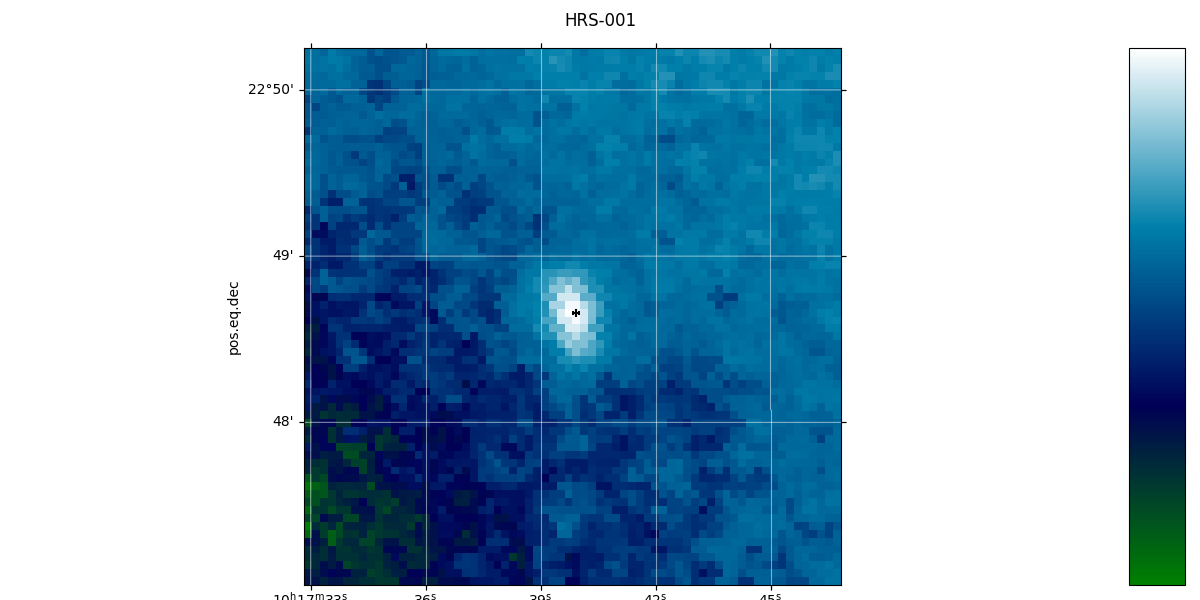

In [8]:
importlib.reload(astrobrowser)
x = astrobrowser.DataExplorer(catalogue, 'ESAVO/P/HERSCHEL/PACS160')

In [11]:
galaxy = HRS_catalogue[x.galaxy_index]
position = SkyCoord(galaxy['R.A.__J.2000_'], galaxy['Dec__J.2000_'],  unit=(u.hourangle, u.deg))
aperture = SkyEllipticalAperture(position, a=galaxy['a']*u.arcsec, b=galaxy['b']*u.arcsec, theta=-galaxy['P.A.']*u.deg)  # Why do I have to invert PA?
pixel_aperture = aperture.to_pixel(x.wcs)
pixel_aperture.positions = [np.array(x.data.shape) / 2]  # dirty fix
pixel_aperture.plot(x.ax1)

In [23]:
flux = pixel_aperture.do_photometry(x.data)[0][0]
mean = flux / pixel_aperture.area
source_mask = np.nanmedian(x.data)
source_mask += np.sqrt(np.nanmean((x.data - source_mask)**2))
x.ax1.contour(x.data, levels=[source_mask], colors=['y'])

bg = np.nanmedian(x.data[x.data < source_mask])
#bg_err = np.sqrt(np.nanmean((bg - x.data[x.data < bg])**2))
bg_err = bg - np.nanmedian(x.data[x.data < bg])
x.ax1_cb.axhline(source_mask, c='y')
x.ax1_cb.axhline(bg+bg_err, c='k', ls=':')
x.ax1_cb.axhline(bg, c='k')
x.ax1_cb.axhline(bg-bg_err, c='k', ls=':')

#scale = (3.2/catalogue[x.galaxy_index]['PIXEL_SIZE_ARCSEC'])**2
scale = 1
corrected_flux = flux - bg*pixel_aperture.area
print(f'area = {pixel_aperture.area:.2f}, mean({mean:.3g}) - bg ({bg:.3g}) = {mean-bg:.3g} +- {bg_err:.3g}')
print(f'flux = {corrected_flux:.3g} +- {bg_err*pixel_aperture.area:.3g} ({flux:.3g})')
#print(f'masked = {np.sum(x.data[x.data > source_mask]) - bg*np.count_nonzero(x.data > source_mask):.3g} ({np.sum(x.data[x.data > source_mask]):.3g})')
#print(f'scaled = {corrected_flux*scale:.3g} +- {bg_err*(pixel_aperture.area)*scale:.3g}')
print('catalogue', galaxy['F_160'], galaxy['sigma_160'], corrected_flux*scale/galaxy['F_160'])

area = 10780.62, mean(0.0216) - bg (0.0197) = 0.00191 +- 0.000777
flux = 20.6 +- 8.37 (233)
catalogue 18.583 1.787 1.1086528021372188


In [13]:
pixel_aperture.area, pixel_aperture.area_overlap(x.data)

(1503.7872867642782, 949.9820243902501)

In [14]:
aperture.positions, pixel_aperture.positions*2, x.data.shape

(<SkyCoord (ICRS): (ra, dec) in deg
     (155.23804167, 25.36483333)>,
 array([[66., 66.]]),
 (66, 66))

In [13]:
galaxy

HRS,CGCG,VCC,UGC,NGC,IC,R.A.__J.2000_,Dec__J.2000_,Type,FLAG_100,F_100,sigma_100,FLAG_160,F_160,sigma_160,a,b,P.A.,Proposal_ID
,,,,,,hms,dms,,,Jy,Jy,,Jy,Jy,arcsec,arcsec,deg,
int16,str7,int16,int16,int16,int16,str11,str11,int16,int16,float32,float32,int16,float32,float32,float32,float32,float32,str29
2,124-004,0,5588,0,0,10:20:57.13,+25:21:53.4,5,1,2.439,0.227,1,2.808,0.179,47.0,45.0,40.0,OT1_lcortese_1


In [12]:
x.header

SIMPLE  = T                                                                     
BITPIX  = -64                                                                   
BSCALE  = 1                                                                     
BZERO   = 0                                                                     
NAXIS   = 2                                                                     
NAXIS1  = 66                                                                    
NAXIS2  = 66                                                                    
CTYPE1  = 'RA---MER'                                                            
CTYPE2  = 'DEC--MER'                                                            
CDELT1  = 0.0007916666666666666                                                 
CDELT2  = 0.0007916666666666666                                                 
CRPIX1  = 33                                                                    
CRPIX2  = 33                

In [15]:
x.header['CDELT1']*3600

2.85